In [6]:
import cv2
from PIL import Image
from sklearn.cluster import BisectingKMeans
import numpy as np
import pandas as pd
import gc
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
import glob
from pprint import pprint
import math
from typing import Literal
import xml.etree.ElementTree as ET
import concurrent

In [7]:
namespaces = {
    'pds': 'http://pds.nasa.gov/pds4/pds/v1',
    'isda': 'https://isda.issdc.gov.in/pds4/isda/v1',
}

In [8]:
def extract_image_shape(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    element_tag = root.findall('.//pds:elements', namespaces)

    shape = []
    for element in element_tag:
        shape.append(int(element.text))

    return shape

In [9]:


def get_slices_from_binary_image_path(
    img_path,
    xml_path,
    slice_height,
    slice_width,
    ksize,
    img_preprocess_func = lambda x,*args,**kwargs : x, 
    img_preprocess_args = [], 
    img_preprocess_kwargs = {}
):
    img = read_pds_binary_image(img_path,'uint8').reshape(*extract_image_shape(xml_path))
    img = img_preprocess_func(img,*img_preprocess_args,**img_preprocess_kwargs)
    
    gc.collect()
    df = pd.DataFrame(slice_and_extract_bbox_data(img, slice_height, slice_width, ksize))
    df['img_path'] = img_path
    return df
    
    

def get_slices_from_image_path_list(
    img_paths, 
    slice_height, 
    slice_width, 
    ksize, 
    img_preprocess_func = lambda x,*args,**kwargs : x, 
    img_preprocess_args = [], 
    img_preprocess_kwargs = {}
):
    data = []
    for img_path in img_paths:
        df = get_slices_from_image_path(
            img_path,
            slice_height,
            slice_width,
            ksize,
            img_preprocess_func,
            img_preprocess_args,
            img_preprocess_kwargs,
        )
        data.append(df)
    df = pd.concat(data, axis = 0, ignore_index = True)
    return df

def get_slices_from_binary_image_path_list(
    img_paths, 
    xml_paths,
    slice_height, 
    slice_width, 
    ksize, 
    img_preprocess_func = lambda x,*args,**kwargs : x, 
    img_preprocess_args = [], 
    img_preprocess_kwargs = {}
):
    data = []
    for img_path in img_paths:
        df = get_slices_from_binary_image_path(
            img_path,
            slice_height,
            slice_width,
            ksize,
            img_preprocess_func,
            img_preprocess_args,
            img_preprocess_kwargs,
        )
        data.append(df)
    df = pd.concat(data, axis = 0, ignore_index = True)
    return df




from PIL import Image, ImageDraw
import numpy as np

def rotate_point(origin, point, angle):
    """
    Rotate a point around a given origin by angle.
    
    Parameters:
    - origin: tuple, (x, y) coordinates of the origin point
    - point: tuple, (x, y) coordinates of the point to rotate
    - angle: float, angle in degrees
    
    Returns:
    - rotated_point: tuple, the rotated point coordinates
    """
    ox, oy = origin
    px, py = point
    angle = np.radians(angle)
    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def extract_rotated_bbox(image_path, bbox, angle):
    """
    Extracts a rotated bounding box from an image.
    
    Parameters:
    - image_path: str, path to the image file
    - bbox: tuple, the bounding box of the region to extract (left, upper, right, lower)
    - angle: float, the angle to rotate the bounding box
    
    Returns:
    - rotated_region: Image object, the extracted and rotated region
    """
    image = Image.open(image_path)
    left, upper, right, lower = bbox
    
    # Define the center of the bounding box
    center = ((left + right) / 2, (upper + lower) / 2)
    
    # Define the corner points of the bounding box
    corners = [
        (left, upper),
        (right, upper),
        (right, lower),
        (left, lower)
    ]
    
    # Rotate each corner point around the center
    rotated_corners = [rotate_point(center, corner, angle) for corner in corners]
    
    # Find the bounding box of the rotated region
    rotated_left = min(x for x, y in rotated_corners)
    rotated_right = max(x for x, y in rotated_corners)
    rotated_upper = min(y for x, y in rotated_corners)
    rotated_lower = max(y for x, y in rotated_corners)
    
    # Crop the image to the new bounding box
    rotated_bbox = (rotated_left, rotated_upper, rotated_right, rotated_lower)
    cropped_image = image.crop(rotated_bbox)
    
    # Rotate the cropped image to get the final result
    rotated_region = cropped_image.rotate(-angle, expand=True)
    
    return rotated_region


def extract_slice(file_path, width, height, x = None, y = None, slice_width = None, slice_height = None):
    """
    file_path : Path of the image File
    width : width of the image
    height : height of the image
    x : x coordinate from where you want to slice
    y : y coordinate from where you want to slice
    slice_width : width of the slice
    slice_height : height of the slice
    """
    # Adjust slice_width and slice_height if they extend beyond image boundaries
    if x + slice_width > width:
        slice_width = width - x
    if y + slice_height > height:
        slice_height = height - y

    # Initialize the slice array
    slice_array = np.zeros((slice_height, slice_width), dtype=np.uint8)

    with open(file_path, 'rb') as f:
        for row in range(slice_height):
            # Calculate the position to seek in the file
            pos = (y + row) * width + x
            f.seek(pos)
            # Read the slice_width bytes for the current row
            row_data = f.read(slice_width)
            # Store the row data in the numpy array
            slice_array[row, :] = np.frombuffer(row_data, dtype=np.uint8)

    return slice_array

def read_pds_binary_image(file_path, data_type):
    """
    Read a PDS binary image from a file.
    
    Parameters:
    - file_path: str, path to the binary image file.
    - width: int, width of the image.
    - height: int, height of the image.
    - data_type: str, data type of the image (e.g., 'uint8', 'uint16', 'float32').
    
    Returns:
    - image: np.ndarray, the image read from the file.
    """
    # Map data type strings to NumPy data types
    data_type_map = {
        'uint8': np.uint8,
        'uint16': np.uint16,
        'float32': np.float32
    }
    
    if data_type not in data_type_map:
        raise ValueError(f"Unsupported data type: {data_type}")
    
    # Read the binary data from the file
    with open(file_path, 'rb') as file:
        binary_data = file.read()
    
    # Convert the binary data to a NumPy array
    image = np.frombuffer(binary_data, dtype=data_type_map[data_type])
    

    
    return image

def plot_images(img_mat, n_cols = 3, max_width = 15):
    h = len(img_mat)
    w = len(img_mat[0])
    total = h * w
    fig_x = max_width
    n_rows = total // n_cols + 1
    fig_y = (max_width / n_cols) * n_rows
    fig,ax = plt.subplots(nrows = n_rows, ncols = n_cols,figsize = (fig_x,fig_y))
    axes = iter(ax.flatten())
    for i in range(h):
        for j in range(w):
            a = next(axes)
            a.imshow(img_mat[i][j])
            a.axis('off')
            a.set_title(f'({i},{j})')
            a.margins(0)
    
    while True:
        try:
            a = next(axes)
            a.axis('off')
            a.margins(0)
        except StopIteration:
            break
    plt.subplots_adjust(wspace=0)
    plt.show()
            
    
    

def get_sliding_slices(img, slice_width = 1200, slice_height = 1200):
    slices = []
    h,w,*c = img.shape
    for i in range(0,h,slice_height):
        row = []
        for j in range(0,w,slice_width):
            row.append(img[i:i + slice_height,j : j + slice_width])
        slices.append(row)
    return slices,len(slices), len(slices[0])

def increase_contrast(image):
    """
    Increase the contrast of a grayscale image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    
    Parameters:
    - image: np.ndarray, input grayscale image.
    
    Returns:
    - contrast_image: np.ndarray, contrast-enhanced image.
    """
    # Create a CLAHE object (Arguments are optional)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_image = clahe.apply(image)
    
    return contrast_image

def canny_edge_detection(image, blur_ksize=(5, 5), blur_sigma=1.4, low_threshold=100, high_threshold=200):
    """
    Apply Canny edge detection to an image.

    Parameters:
    - image_path: str, path to the input image.
    - blur_ksize: tuple, kernel size for Gaussian blur.
    - blur_sigma: float, standard deviation for Gaussian blur.
    - low_threshold: int, lower threshold for Canny edge detection.
    - high_threshold: int, upper threshold for Canny edge detection.

    Returns:
    - edges: np.ndarray, edges detected in the image.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, blur_ksize, blur_sigma)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges

def morphological_transform(original_img):
    kernel = np.ones(shape=(7,7), dtype=np.uint8)
    transformed_image = cv2.morphologyEx(cv2.morphologyEx(cv2.morphologyEx(original_img, cv2.MORPH_OPEN, kernel), cv2.MORPH_CLOSE, kernel), cv2.MORPH_GRADIENT, kernel)
#     binary_img = cv2.adaptiveThreshold(transformed_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 0.5)
    return transformed_image
#         cv2.imwrite('transformed.png', transformed_image)
#         cv2.imwrite('binary.png', binary_img)



def get_morphological_segmentation_mask(image,kernel):
    kernel = np.array(kernel, dtype = np.uint8)
    segmented_image = cv2.morphologyEx(cv2.morphologyEx(cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel), cv2.MORPH_CLOSE, kernel), cv2.MORPH_GRADIENT, kernel)
    segmented_image = cv2.adaptiveThreshold(segmented_image, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 0.5)
    segmented_image = segmented_image*255
    return segmented_image


def circle_hough_transform(img,mask, resized_size = None):
    cimg = img.copy()
    mask = mask.copy()
    if resized_size is not None:
        mask = cv2.resize(mask,resized_size)
        cimg = cv2.resize(cimg,resized_size)

    circles = cv2.HoughCircles(mask,cv2.HOUGH_GRADIENT,1,50,param1=50,param2=35,
                              minRadius=0,maxRadius=200)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cimg = cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cimg  = cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    return cimg

def adaptive_intensity_scaling(img, epsilon = 0.0001,quantiles = [0.25,0.95]):
    img_reciprocated = img.astype(np.float64)
    min_val,max_val = np.quantile(img_reciprocated.flatten(),quantiles)
    img_reciprocated[img_reciprocated < min_val] = min_val
    img_reciprocated[img_reciprocated > max_val] = max_val
    img_reciprocated = (img_reciprocated - img_reciprocated.min()) / (img_reciprocated.max() - img_reciprocated.min() + epsilon)
    img_reciprocated = (img_reciprocated * 255).astype(np.uint8)
    return img_reciprocated

def reciprocation_transforms(img,quantiles = [0.15,0.5,0.75], masks = ['min','none','max']):
    img_reciprocated = img.astype(np.float64)
    img_reciprocated = (img_reciprocated - img_reciprocated.min()) / (img_reciprocated.max() - img_reciprocated.min() + 0.01)
    min_val,med_val,max_val = np.quantile(img_reciprocated.flatten(),quantiles)
    img_reciprocated[img_reciprocated < min_val] = max_val if masks[0] == 'max' else min_val
    if masks[1] != 'none':
        img_reciprocated[(img_reciprocated > min_val)  &  (img_reciprocated < max_val)] =  max_val if masks[1] == 'max' else (med_val if masks[1] == 'med' else min_val)
    img_reciprocated[img_reciprocated > max_val] = max_val =  max_val if masks[2] == 'max' else min_val
    img_reciprocated = (img_reciprocated - min_val) / (max_val - min_val + 0.001) 

    img_reciprocated = (img_reciprocated * 255).astype(np.uint8)
    return img_reciprocated

def terneary_clustering(img, cluster_intensities = None):
    h,w = img.shape[:2]
    cluster = KMeans(n_clusters = 3,max_iter = 1000)
    labels = cluster.fit_predict(img.flatten().reshape(-1,1))
    if cluster_intensities:
        sorted_clusters = sorted(list(zip(range(cluster.cluster_centers_.shape[0]),cluster.cluster_centers_)),key = lambda x : x[1])
        for i,c in enumerate(cluster_intensities):
            cluster.cluster_centers_[sorted_clusters[i][0]] = sorted_clusters[i][1]
    compressed_image = recreate_image(cluster.cluster_centers_, labels, h, w).astype('uint8')
    return compressed_image

def detect_bound_islands(mask_image, image,ret_islands = False, thickness = 2, shade = 0):
    num_labels, labels_im = cv2.connectedComponents(mask_image)

    # Prepare the output image
    output_image = image.copy()
    print(num_labels)
    # Iterate through each component
    for label in range(1, num_labels):  # Start from 1 to exclude the background
        # Create a binary mask for the current label
        mask = labels_im == label
        # Find coordinates of pixels belonging to this label
        coords = np.column_stack(np.where(mask))
        # Find bounding box for the label
        x, y, w, h = cv2.boundingRect(coords)
        

        # Draw the bounding box on the original image
        output_image = cv2.rectangle(output_image, (y,x), (y + h, x + w), shade,thickness)
        
    if ret_islands:
        return output_image,labels_im
    return output_image

def draw_bounding_boxes_from_rects(
    img,
    bboxes,
    shade = 0,
    thickness = 2,
):
    output = img.copy()
    for stats in bboxes:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        output = cv2.rectangle(output,(x,y),(x + w, y + h),shade,thickness)
    return output
    
def detect_bound_islands_with_stats(
    mask_image, 
    image,ret_image = True, 
    ret_islands = False, 
    thickness = 2, 
    shade = 0, 
    circularity_threshold = None,
    min_area_threshold = None,
    max_area_threshold = None,
):
    output = cv2.connectedComponentsWithStats(mask_image,)
    (numLabels, labels, stats, centroids) = output
    # Prepare the output imageoutput_image = img[0:1200,0:1200,0].copy()
    output_arr = []
    if (ret_image):
        output_image = image.copy()
        output_arr.append(output_image)
    for i in range(1, numLabels):
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if min_area_threshold is not None and area < min_area_threshold:
            continue;
        if max_area_threshold is not None and area > max_area_threshold:
            continue
        if circularity_threshold is not None:
            circularity = calculate_circularity_of_boolean_mask((labels== i))
            if circularity < circularity_threshold:
                continue

        if (ret_image):
            output_image = cv2.rectangle(output_image, (x,y), (x+ w, y + h), shade,thickness)
            
    if ret_islands:
        output_arr.extend([stats,centroids,labels])
    return output_arr
    





def combined_transforms(
    img,
    adaptive_intensity_scaling_args = [],
    adaptive_intensity_scaling_kwargs = {'quantiles' : [0.05,0.95]},
    reciprocation_transforms_args = [],
    reciprocation_transforms_kwargs = {'quantiles' : [0.20,0.5,0.80], 'masks' : ['min','med','max']},
    median_blur_args = [],
    median_blur_kwargs = {'ksize' : 7},
    detect_bound_islands_with_stats_white_args = [],
    detect_bound_islands_with_stats_white_kwargs = {
        'ret_islands':True,'thickness':2
    },
    detect_bound_islands_with_stats_black_args = [],
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_islands':True,'thickness':2
    },
):
    img = adaptive_intensity_scaling(img,*adaptive_intensity_scaling_args,**adaptive_intensity_scaling_kwargs)
    coarse_mask = reciprocation_transforms(img,*reciprocation_transforms_args, **reciprocation_transforms_kwargs)
    mask = cv2.medianBlur(coarse_mask,*median_blur_args,**median_blur_kwargs)
    white_bounding_box, white_coords, white_centroids = detect_bound_islands_with_stats(
        (mask == mask.max())*np.uint8(255), img,*detect_bound_islands_with_stats_white_args,**detect_bound_islands_with_stats_white_kwargs
    )
    black_bounding_box, black_coords, black_centroids = detect_bound_islands_with_stats(
        (mask == mask.min())*np.uint8(255), img,*detect_bound_islands_with_stats_black_args,**detect_bound_islands_with_stats_black_kwargs
    )
    return {
        'coarse_mask' : coarse_mask,
        'mask' : mask,
        'white_bounding_box' : white_bounding_box,
        'white_coords' : white_coords,
        'white_centroids' : white_centroids,
        'black_bounding_box' : black_bounding_box,
        'black_coords' : black_coords,
        'black_centroids' : black_centroids,
    }

def fit_ellipse(img,mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_copy = img.copy()
    h,w = img_copy.shape[:2]
    img_copy = img_copy.reshape(h,w,-1) + np.array([[[0,0,0]]]).astype(np.uint8)

    for contour in contours:
        if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
            ellipse = cv2.fitEllipse(contour)
            center, axes, angle = ellipse

            # Check if the dimensions of the ellipse are valid
            if axes[0] > 0 and axes[1] > 0:
                img_copy = cv2.ellipse(img_copy, ellipse, (0, 255, 0), 1)  # Draw the ellipse
    return img_copy

def show_img(img,figsize = (10,10)):
    plt.figure(figsize = (10,10))
    h,w = img.shape[:2]
    plt.imshow(img.reshape(h,w,-1) + [[[0,0,0]]])
    plt.axis('off')
    plt.show()

def slice_and_plot(img, slice_height, slice_width):
    img_slices,h,w = get_sliding_slices(img,slice_height,slice_width)
    img_slices_df = pd.DataFrame(img_slices)
    return h,w,img_slices_df,img_slices

def get_paths_by_re(base_directory, regular_expression):
    search_pattern = os.path.join(base_directory,regular_expression)
    # Use glob to find all files matching the pattern
    png_files = glob.glob(search_pattern, recursive=True)
    
    return png_files

def calculate_circularity_of_boolean_mask(boolean_mask):
    """
    Calculate the circularity of the connected component in a boolean mask using OpenCV.
    
    Parameters:
    - boolean_mask: np.array, a binary mask where the component is True.
    
    Returns:
    - float, the circularity of the component.
    """
    # Convert the boolean mask to uint8
    uint8_mask = (boolean_mask * 255).astype(np.uint8)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(uint8_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return -1
    # Assuming a single connected component
    contour = contours[0]
    
    # Calculate area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if perimeter == 0:
        return 0
    
    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter ** 2))
    return circularity

def calculate_convexity(boolean_mask):
    """
    Calculate the convexity of the connected component in a boolean mask using OpenCV.
    
    Parameters:
    - boolean_mask: np.array, a binary mask where the component is True.
    
    Returns:
    - float, the convexity of the component.
    """
    # Convert the boolean mask to uint8
    uint8_mask = (boolean_mask * 255).astype(np.uint8)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(uint8_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return -1
    
    # Assuming a single connected component
    contour = contours[0]
    
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate the convex hull of the contour
    hull = cv2.convexHull(contour)
    
    # Calculate the perimeter of the convex hull
    hull_perimeter = cv2.arcLength(hull, True)
    
    if perimeter == 0:
        return float('inf')
    
    # Calculate convexity
    convexity = hull_perimeter / perimeter
    return convexity


def calculate_circularity_and_convexity(contour,area = None):
    if len(contours) == 0:
        return -1
    # Assuming a single connected component
    contour = contours[0]
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    # Calculate the convex hull of the contour
    hull = cv2.convexHull(contour)
    # Calculate the perimeter of the convex hull
    hull_perimeter = cv2.arcLength(hull, True)
    
    if perimeter == 0:
        return float('inf')
    
    # Calculate convexity
    convexity = hull_perimeter / perimeter
    return convexity

In [24]:
def recreate_image_from_cluster_labels(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i, j] = codebook[labels[label_idx]]
            label_idx += 1
    return image
def terneary_clustering(image, cluster_intensities = None):
    """
    
    """
    h,w = image.shape[:2]
    cluster = KMeans(n_clusters = 3,max_iter = 1000)
    labels = cluster.fit_predict(image.flatten().reshape(-1,1))
    if cluster_intensities:
        sorted_clusters = sorted(list(zip(range(cluster.cluster_centers_.shape[0]),cluster.cluster_centers_)),key = lambda x : x[1])
        for i,c in enumerate(cluster_intensities):
            cluster.cluster_centers_[sorted_clusters[i][0]] = sorted_clusters[i][1]
    compressed_image = recreate_image_from_cluster_labels(cluster.cluster_centers_, labels, h, w).astype('uint8')
    return compressed_image

def terneary_clustering_thresholding(image, cluster_intensities = None):
    """
    
    """
    h,w = image.shape[:2]
    cluster = KMeans(n_clusters = 3,max_iter = 1000)
    labels = cluster.fit_predict(image.flatten().reshape(-1,1))
    if cluster_intensities:
        sorted_clusters = sorted(list(zip(range(cluster.cluster_centers_.shape[0]),cluster.cluster_centers_)),key = lambda x : x[1])
        for i,c in enumerate(cluster_intensities):
            cluster.cluster_centers_[sorted_clusters[i][0]] = sorted_clusters[i][1]
    compressed_image = recreate_image_from_cluster_labels(cluster.cluster_centers_, labels, h, w).astype('uint8')
    return compressed_image

def adaptive_intensity_scaling(
    image : np.ndarray[np.uint8], 
    epsilon = 0.0001,
    quantiles : tuple[int,int] = (0.25,0.95),
    rescale = False,
    ret_thresholds = False,
) -> np.ndarray[np.uint8]:
    """
    Adaptively rescales the brightness of the image by performing min max scaling between the 
    -quantiles[0]% quantile value (value which is greater than quantiles[0]% of all values present)
    and
    -quantiles[1]% quantile value (value which is greater than quantiles[1]% of all values present)
    epsilon is a small constant added to prevent zero division error when min max scaling
    """
    image_reciprocated = image.astype(np.float64)
    min_val,max_val = np.quantile(image_reciprocated.flatten(),quantiles)
    image_reciprocated[image_reciprocated < min_val] = min_val
    image_reciprocated[image_reciprocated > max_val] = max_val
    if rescale:
        image_reciprocated = (image_reciprocated - image_reciprocated.min()) / (image_reciprocated.max() - image_reciprocated.min() + epsilon)
        image_reciprocated = (image_reciprocated * 255)
        
    if ret_thresholds:
        return image_reciprocated.astype(np.uint8), min_val,max_val
    return image_reciprocated.astype(np.uint8)

def terneary_thresholding_transform(
    image : np.ndarray[np.uint8],
    quantiles : tuple[int,int,int]= [0.15,0.5,0.75], 
    mask_color : tuple[
            Literal['max', 'min'], 
            Literal['max' , 'min' , 'med'],
            Literal['max','min']
        ] = ['min','none','max']
)->np.ndarray[np.uint8]: 
    """
    quantiles[0] is the lower bound of percentile values below this will be painted black
    quantiles[1] is the median of the values for the most cases. Other pixel values will be painted with value of this percentile
    quantiles[2] is the upper bound of the percentile value above this will be painted white
    
    mask_color[0,1,2] is the color of the mask 0 for values:
    -mask_color[0] for below quantiles[0]%ile
    -mask_color[2] for above quantiles[1]%ile
    -mask_color[1] for between above two mentined percentiles
    
    # Not necessaryt to change these values you can get same results later through boolean operations as there are only 3 colors
    it can take values 'min' if you want to paint with quantile[0]%ile value percentile, 'max' if you want to paint with quantiles[2]%ile value
    """
    image_reciprocated = image.astype(np.float64)
    image_reciprocated = (image_reciprocated - image_reciprocated.min()) / (image_reciprocated.max() - image_reciprocated.min() + 0.01)
    min_val,med_val,max_val = np.quantile(image_reciprocated.flatten(),quantiles)
    image_reciprocated[image_reciprocated < min_val] = max_val if mask_color[0] == 'max' else min_val
    if mask_color[1] != 'none':
        image_reciprocated[(image_reciprocated > min_val)  &  (image_reciprocated < max_val)] =  max_val if mask_color[1] == 'max' else (med_val if mask_color[1] == 'med' else min_val)
    image_reciprocated[image_reciprocated > max_val] = max_val =  max_val if mask_color[2] == 'max' else min_val
    image_reciprocated = (image_reciprocated - min_val) / (max_val - min_val + 0.001) 

    image_reciprocated = (image_reciprocated * 255).astype(np.uint8)
    return image_reciprocated



def draw_bounding_boxes_from_rects(
    image : np.ndarray[np.uint8],
    bboxes : np.ndarray[np.int32],
    shade = 0,
    thickness = 2,
    inplace = False,
):
    """
    Draws the rectangular bounding boxes given an bboxes array of shape (n,5)
    this type of bbox is returned by cv2.connected_components_with_stats where 5th value is area of the connected component
    
    shade : color of the bounding box, can be color or grayscale value
    thickness : thickness of the bounding box
    inplace : if you want to draw bounding boxes directly on the image, if you don't want to copy the image to save memory
    """
    output = None
    if inplace:
        output = image
    else:
        output = image.copy()
    
    
    for stats in bboxes:
        x = stats[cv2.CC_STAT_LEFT]
        y = stats[cv2.CC_STAT_TOP]
        w = stats[cv2.CC_STAT_WIDTH]
        h = stats[cv2.CC_STAT_HEIGHT]
        output = cv2.rectangle(output,(x,y),(x + w, y + h),shade,thickness)
    return output
    
def detect_bound_islands_with_stats(
    mask_image : np.ndarray[np.uint8], 
    ret_labels = False, 
    min_circularity_threshold = None,
    min_area_threshold = None,
    max_area_threshold = None,
    min_bbox_area_threshold = None,
    max_bbox_area_threshold = None,
)  -> dict:
    """
    mask_image is the image of blobs on which islands and their stats are to be detected
    """
    output = cv2.connectedComponentsWithStats(mask_image,)
    (numLabels, labels, stats, centroids) = output
    labels_df = pd.DataFrame({'label_id' : list(range(1,numLabels))}).astype(np.int32)
    stats_df = pd.DataFrame(stats[1:],columns=['coords_x', 'coords_y','width','height','area']).astype(np.float32)
    stats_df['bbox_area' ] = stats_df['height'] * stats_df['width']
    centroids_df = pd.DataFrame(centroids[1:],columns=['c_x','c_y']).astype(np.float32)
    combined_df = pd.concat([labels_df,stats_df,centroids_df], axis = 1)
    combined_df['circularity'] = np.nan
    array_mask = pd.Series(np.full((numLabels - 1,),True))
    if min_bbox_area_threshold is not None :
        array_mask = array_mask & (combined_df['bbox_area'] >= min_bbox_area_threshold)
    if max_bbox_area_threshold is not None :
        array_mask = array_mask & (combined_df['bbox_area'] <= max_bbox_area_threshold)
    if min_area_threshold is not None :
        array_mask = array_mask & (combined_df['area'] >= min_area_threshold)
    if max_area_threshold is not None :
        array_mask = array_mask & (combined_df['area'] <= max_area_threshold)
    
    for i,val in list(combined_df.loc[array_mask,'label_id'].items()):
        # extract the connected component statistics and centroid for
        
        if min_circularity_threshold is not None:
            circularity = calculate_circularity_of_boolean_mask((labels==val),)
            if circularity < min_circularity_threshold:
                array_mask[i] = False
            else:
                combined_df.loc[i,'circularity'] = circularity
    combined_df['circularity'] = combined_df['circularity'].astype(np.float32) 
    output_dict = {}
    output_dict['df'] = combined_df.loc[array_mask,:].reset_index().copy()
    if ret_labels:
        output_dict['label_image'] = labels
    return output_dict

def combined_transforms(
    image,
    adaptive_intensity_scaling_args = [],
    adaptive_intensity_scaling_kwargs = {'quantiles' : [0.05,0.95]},
    terneary_thresholding_transform_args = [],
    terneary_thresholding_transform_kwargs = {'quantiles' : [0.20,0.5,0.80], 'mask_color' : ['min','med','max']},
    median_blur_args = [],
    median_blur_kwargs = {'ksize' : 7},
    detect_bound_islands_with_stats_white_args = [],
    detect_bound_islands_with_stats_white_kwargs = {
        'ret_islands':True,
    },
    detect_bound_islands_with_stats_black_args = [],
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_islands':True,
    },
):
    """
    Don't change anything unless you understand the functions used in it. The name of parameters are obvious. kwargs are keyword arguments and args are normal function arguments
    It returns the dictionary of following:
    'coarse_mask' : The mask before the median blur and after terneary thresholding
    'mask' : The mask after mediam blur
    """
    image = adaptive_intensity_scaling(image,*adaptive_intensity_scaling_args,**adaptive_intensity_scaling_kwargs)
    coarse_mask = terneary_thresholding_transform(image,*terneary_thresholding_transform_args, **terneary_thresholding_transform_kwargs)
    mask = cv2.medianBlur(coarse_mask,*median_blur_args,**median_blur_kwargs)
    white_stats = detect_bound_islands_with_stats(
        (mask == mask.max())*np.uint8(255),*detect_bound_islands_with_stats_white_args,**detect_bound_islands_with_stats_white_kwargs
    )
    black_stats = detect_bound_islands_with_stats(
        (mask == mask.min())*np.uint8(255),*detect_bound_islands_with_stats_black_args,**detect_bound_islands_with_stats_black_kwargs
    )
    return {
        'coarse_mask' : coarse_mask,
        'mask' : mask,
        'white_stats_df' : white_stats.get('df'),
        'white_label_image' : white_stats.get('label_image'),
        'black_stats_df' : black_stats.get('df'),
        'black_label_image' : black_stats.get('label_image'),
    }

def show_image(image,figsize = (7,7)):
    plt.figure(figsize = figsize)
    h,w = image.shape[:2]
    plt.imshow(image.reshape(h,w,-1) + [[[0,0,0]]])
    plt.axis('off')
    plt.show()


def calculate_circularity_of_boolean_mask(boolean_mask, area = None):
    """
    Calculate the circularity of the connected component in a boolean mask using OpenCV.
    
    Parameters:
    - boolean_mask: np.array, a binary mask where the component is True.
    
    Returns:
    - float, the circularity of the component.
    """
    # Convert the boolean mask to uint8
    uint8_mask = (boolean_mask * 255).astype(np.uint8)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(uint8_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        raise ValueError("No connected component found in the boolean mask.")
    # Assuming a single connected component
    contour = contours[0]
    
    # Calculate area and perimeter
    if area is None:
        area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if perimeter == 0:
        return 0
    
    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter ** 2))
    return circularity

def plot_images_list(image_list, n_cols = 3, max_width = 15):
    h = len(image_list)
    total = h 
    fig_x = max_width
    n_rows = math.ceil(total / n_cols)
    fig_y = (max_width / n_cols) * n_rows
    fig,ax = plt.subplots(nrows = n_rows, ncols = n_cols,figsize = (fig_x,fig_y))
    axes = iter(ax.flatten())
    for i in range(h):
        a = next(axes)
        a.imshow(image_list[i].reshape(image_list[i].shape[0], image_list[i].shape[1],-1) + np.array([[[0,0,0]]]))
        a.axis('off')
        a.set_title(f'({i})')
        a.margins(0)
    
    while True:
        try:
            a = next(axes)
            a.axis('off')
            a.margins(0)
        except StopIteration:
            break
    plt.subplots_adjust(wspace=0)
    plt.show()
    
def overlay_segmentation_mask(image, mask, color=(0, 0, 255), alpha=0.5):
    """
    Overlay a binary segmentation mask on an image with a translucent colored layer.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the binary segmentation mask image.
        color (tuple): Color of the overlay in BGR format.
        alpha (float): Opacity of the overlay.

    Returns:
        np.array: Image with the overlay.
    """
    mask = mask > 0
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    overlay = np.zeros_like(image, dtype=np.uint8)
    overlay[:] = color
    blended = image.copy()
    blended[mask] = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)[mask]
    return blended

In [11]:
    
def combined_transforms_2(
    image,
    adaptive_intensity_scaling_args = [],
    adaptive_intensity_scaling_kwargs = {'quantiles' : [0.05,0.95]},
    terneary_clustering_thresholding_args = [],
    terneary_clustering_thresholding_kwargs = {},
    median_blur_args = [],
    median_blur_kwargs = {'ksize' : 7},
    detect_bound_islands_with_stats_white_args = [],
    detect_bound_islands_with_stats_white_kwargs = {
        'ret_labels':True,
    },
    detect_bound_islands_with_stats_black_args = [],
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_labels':True,
    },
):
    """
    Don't change anything unless you understand the functions used in it. The name of parameters are obvious. kwargs are keyword arguments and args are normal function arguments
    It returns the dictionary of following:
    'coarse_mask' : The mask before the median blur and after terneary thresholding
    'mask' : The mask after mediam blur
    """
    image = adaptive_intensity_scaling(image,*adaptive_intensity_scaling_args,**adaptive_intensity_scaling_kwargs)
    coarse_mask = terneary_clustering_thresholding(image,*terneary_clustering_thresholding_args, **terneary_clustering_thresholding_kwargs)
    mask = cv2.medianBlur(coarse_mask,*median_blur_args,**median_blur_kwargs)
    white_stats = detect_bound_islands_with_stats(
        (mask == mask.max())*np.uint8(255),*detect_bound_islands_with_stats_white_args,**detect_bound_islands_with_stats_white_kwargs
    )
    black_stats = detect_bound_islands_with_stats(
        (mask == mask.min())*np.uint8(255),*detect_bound_islands_with_stats_black_args,**detect_bound_islands_with_stats_black_kwargs
    )
    return {
        'coarse_mask' : coarse_mask,
        'mask' : mask,
        'white_stats_df' : white_stats.get('df'),
        'white_label_image' : white_stats.get('label_image'),
        'black_stats_df' : black_stats.get('df'),
        'black_label_image' : black_stats.get('label_image'),
    }

def combined_transforms_3(
    image,
    adaptive_intensity_scaling_args = [],
    adaptive_intensity_scaling_kwargs = {'quantiles' : [0.05,0.95]},
    terneary_clustering_thresholding_args = [],
    terneary_clustering_thresholding_kwargs = {},
    median_blur_args = [],
    median_blur_kwargs = {'ksize' : 7},
    detect_bound_islands_with_stats_white_args = [],
    detect_bound_islands_with_stats_white_kwargs = {
        'ret_labels':True,
    },
    detect_bound_islands_with_stats_black_args = [],
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_labels':True,
    },
):
    """
    Don't change anything unless you understand the functions used in it. The name of parameters are obvious. kwargs are keyword arguments and args are normal function arguments
    It returns the dictionary of following:
    'coarse_mask' : The mask before the median blur and after terneary thresholding
    'mask' : The mask after mediam blur
    """
#     image = adaptive_intensity_scaling(image,*adaptive_intensity_scaling_args,**adaptive_intensity_scaling_kwargs)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    coarse_mask = terneary_clustering_thresholding(image,*terneary_clustering_thresholding_args, **terneary_clustering_thresholding_kwargs)
    mask = cv2.medianBlur(coarse_mask,*median_blur_args,**median_blur_kwargs)
    white_stats = detect_bound_islands_with_stats(
        (mask == mask.max())*np.uint8(255),*detect_bound_islands_with_stats_white_args,**detect_bound_islands_with_stats_white_kwargs
    )
    black_stats = detect_bound_islands_with_stats(
        (mask == mask.min())*np.uint8(255),*detect_bound_islands_with_stats_black_args,**detect_bound_islands_with_stats_black_kwargs
    )
    return {
        'coarse_mask' : coarse_mask,
        'mask' : mask,
        'white_stats_df' : white_stats.get('df'),
        'white_label_image' : white_stats.get('label_image'),
        'black_stats_df' : black_stats.get('df'),
        'black_label_image' : black_stats.get('label_image'),
    }



### Functions for morphological trnsforms

In [12]:
def erosion_and_dialation_using_stream(img,stream = "",iterations = 1,kernel = (3,3)):
    output = img.copy();
    for i in stream:
        if i == 'D':
            output = cv2.dilate(output, kernel, iterations=iterations)
        else:
            output = cv2.erode(output, kernel, iterations=iterations)
    return output

def get_elliptic_element(erosion_size,shape = 2):
    return cv2.getStructuringElement(shape , (2 * erosion_size + 1, 2 * erosion_size + 1),(erosion_size, erosion_size))

def morphological_smoothing(image, kernel):
    # Create a kernel for morphological operations
    
    # Apply dilation followed by erosion (opening operation)
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    smoothed_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    return smoothed_image

# Image Visualizations

In [13]:
img_slice = extract_slice(
#     file_path='/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6/dataset/ch2_ohr_ncp_20200824T0806596861_d_img_d18/data/calibrated/20200824/ch2_ohr_ncp_20200824T0806596861_d_img_d18.img',
    file_path = '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6/dataset/ch2_ohr_ncp_20190906T1246532096_d_img_d18/data/calibrated/20190906/ch2_ohr_ncp_20190906T1246532096_d_img_d18.img',
    width = 12000,
    height = 63230,
    x = 0,
    y = 0,
    slice_width = 12000,
    slice_height = 12000,
)
print(img_slice.shape)

(12000, 12000)


In [14]:
# img_slice = cv2.imread(
#     '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6/dataset/ch2_ohr_ncp_20190906T1246532096_d_img_d18/browse/calibrated/20190906/ch2_ohr_ncp_20190906T1246532096_b_brw_d18.png',
#     cv2.IMREAD_GRAYSCALE
# )[-1:-1200:-1,:1200]

In [15]:
img_slice = cv2.resize(img_slice,(1200,1200))

In [16]:
# img_slice = img[:1200,:1200,0]

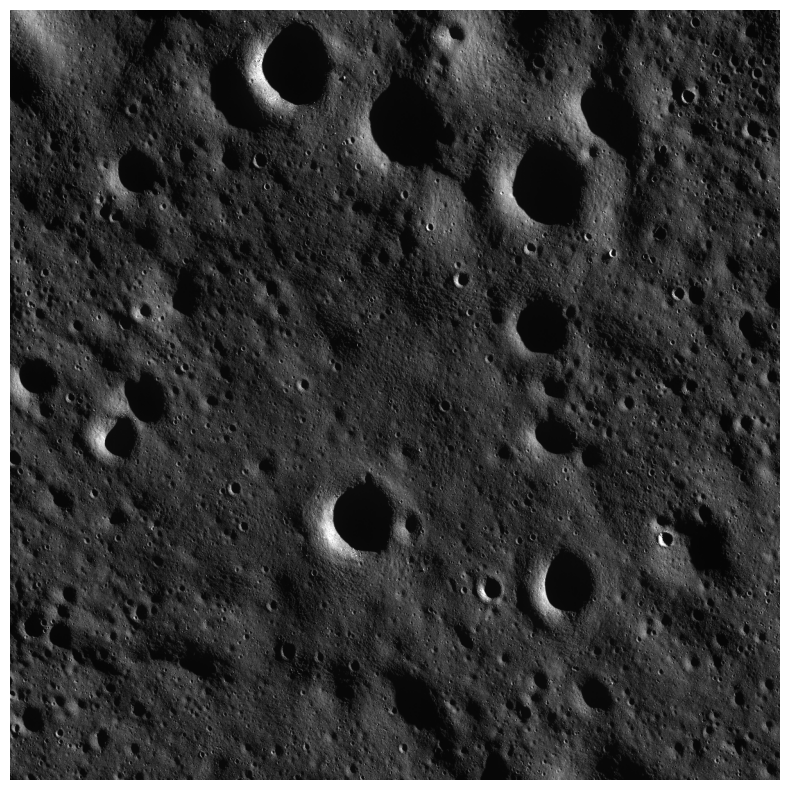

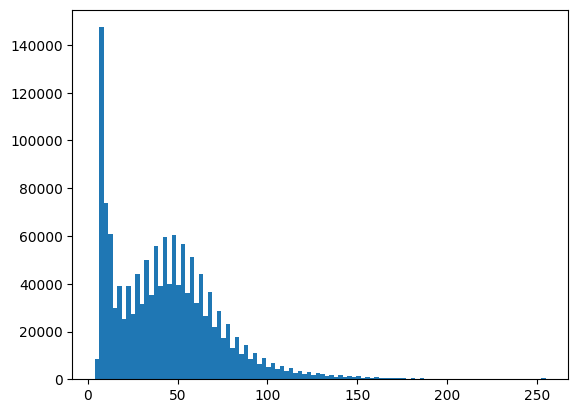

In [17]:
show_img(img_slice)
plt.hist(img_slice.flatten(), bins = 100)
plt.show()

In [18]:
# adapted = adaptive_intensity_scaling(img_slice,quantiles = [0.02,0.98])
clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50,50)).apply(img_slice)


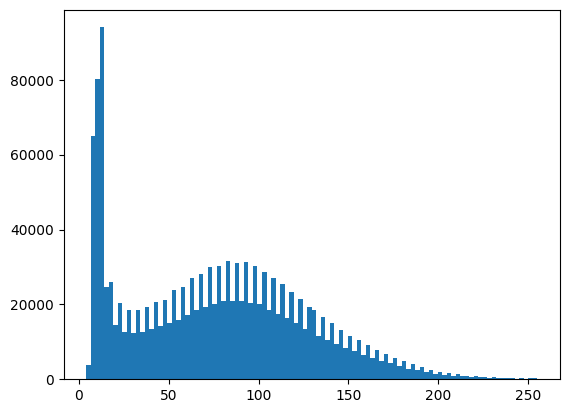

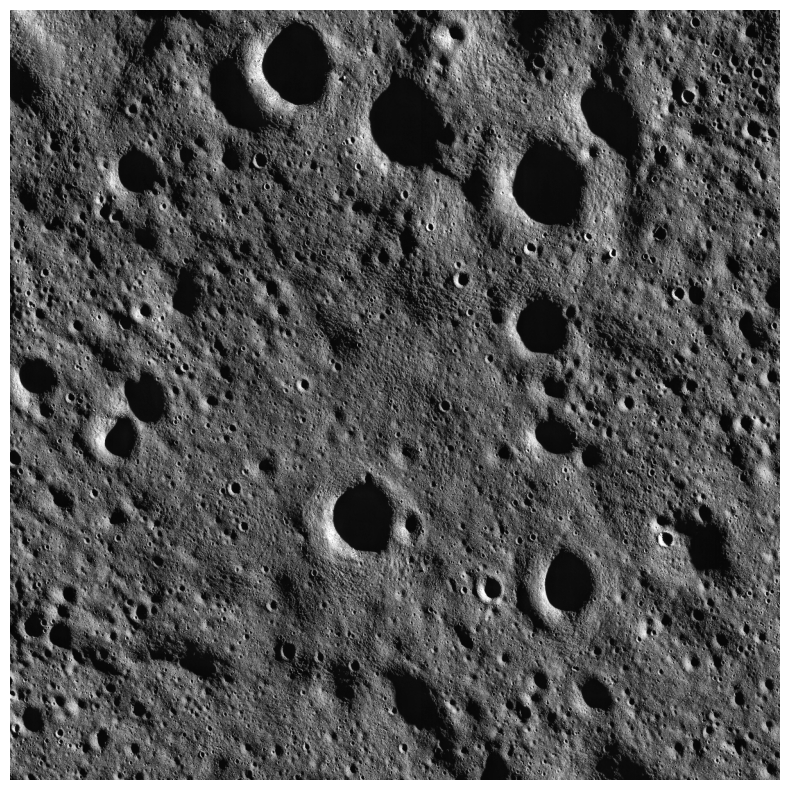

In [19]:
plt.hist(clahe_adapted.flatten(), bins = 100)
plt.show()
show_img((clahe_adapted))

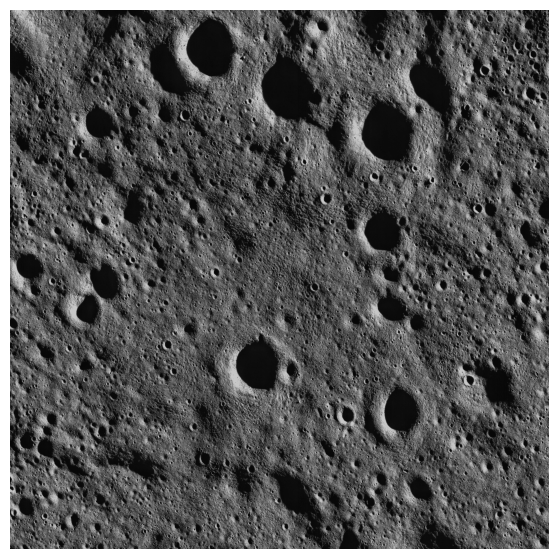

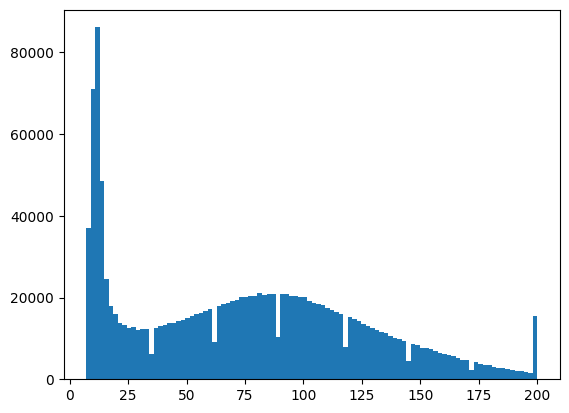

In [34]:
bias_adaption = adaptive_intensity_scaling(clahe_adapted,quantiles=[0.01,0.99])
show_image(bias_adaption)
plt.hist(bias_adaption.flatten(), bins = 100)
plt.show()

In [35]:
def get_segmentation_masks(image):
    eroded_img = erosion_and_dialation_using_stream(
        image,
        stream = 'ED',
        iterations = 1,
        kernel = get_elliptic_element(1,0)
    )
    clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50)).apply(eroded_img)
    bias_adaption = adaptive_intensity_scaling(clahe_adapted,quantiles=[0.10,0.90], rescale = True)
    clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50)).apply(bias_adaption)
    bias_adaption = (clahe_adapted < 15)*np.uint8(255)
    return bias_adaptation

6.0 80.0
6.0 255.0


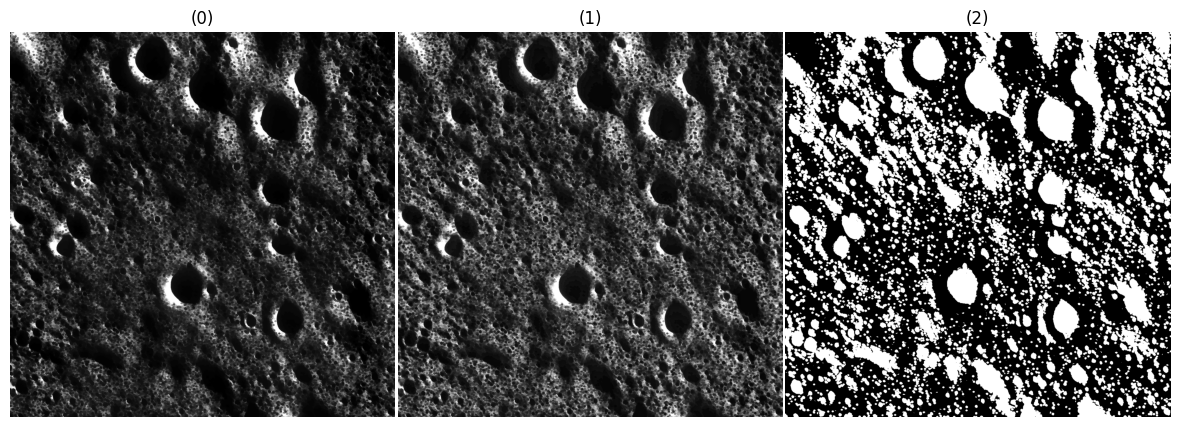

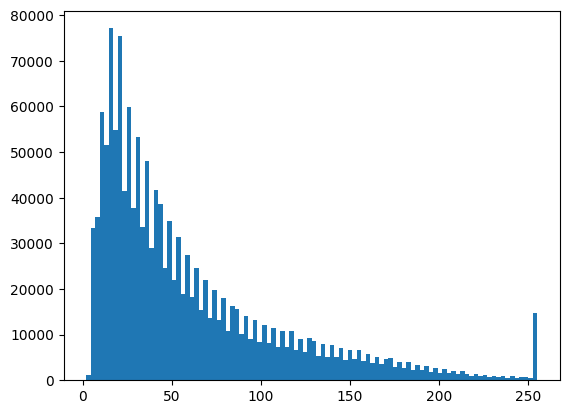

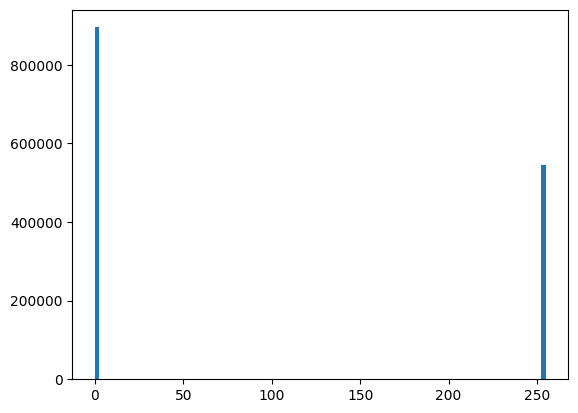

In [36]:
# adapted = adaptive_intensity_scaling(img_slice,quantiles = [0.02,0.98])
# denoised_slice = cv2.fastNlMeansDenoising(img_slice, h=10, templateWindowSize=7, searchWindowSize=50)
eroded_img = erosion_and_dialation_using_stream(
        img_slice,
        stream = 'E',
        iterations = 1,
        kernel = get_elliptic_element(3,2)
    )
rescaled_img, min_val,max_val = adaptive_intensity_scaling(eroded_img,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
print(min_val,max_val)
clahe_adapted = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img)
# bias_adaption = adaptive_intensity_scaling(clahe_adapted,quantiles=[0.10,0.90], rescale = True)
# clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50)).apply(bias_adaption)
bias_adaption, min_val,max_val= adaptive_intensity_scaling(clahe_adapted,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
print(min_val,max_val)

bias_adaption = ((bias_adaption < 25))*np.uint8(255)


plot_images_list([rescaled_img,clahe_adapted,bias_adaption])
plt.hist(clahe_adapted.flatten(), bins = 100)
plt.show()
plt.hist(bias_adaption.flatten(), bins = 100)
plt.show()

In [37]:
smoothed = erosion_and_dialation_using_stream(
    (bias_adaption == bias_adaption.max())*np.uint8(255),
    stream = 'ED',
    iterations = 1,
    kernel = get_elliptic_element(4,2)
)
# smoothed = erosion_and_dialation_using_stream(
#     smoothed,
#     stream = 'D',
#     iterations = 1,
#     kernel = get_elliptic_element(5,2)
# )

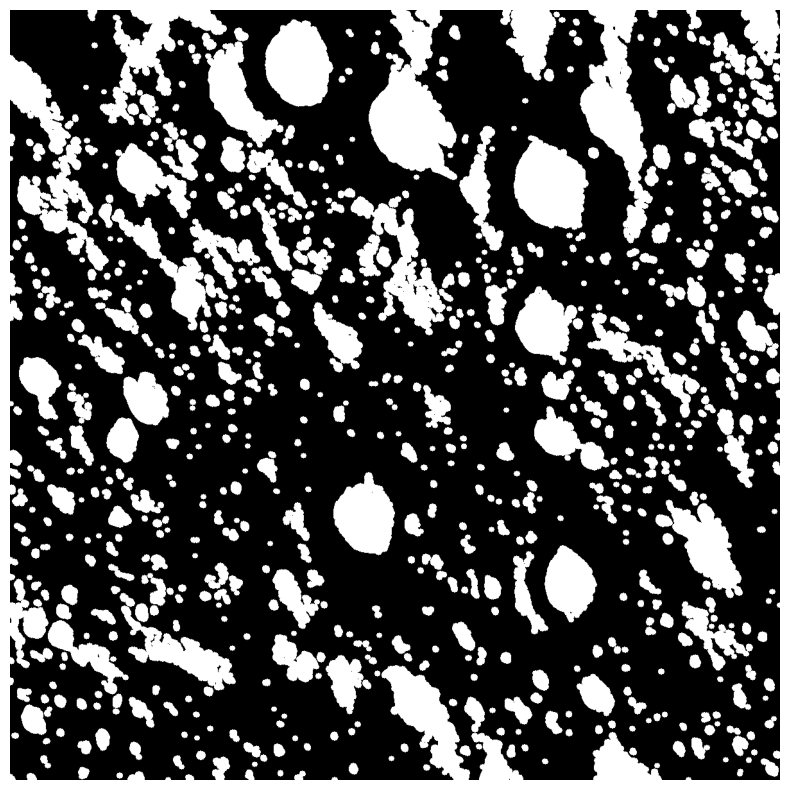

In [39]:
show_img(smoothed)

In [40]:
# smoothed_white = erosion_and_dialation_using_stream(
#     (bias_adaption == bias_adaption.max())*np.uint8(255),
#     stream = 'D',
#     iterations = 1,
#     kernel = get_elliptic_element(5,2)
# )
# smoothed_white = erosion_and_dialation_using_stream(
#     smoothed_white,
#     stream = 'D',
#     iterations = 1,
#     kernel = get_elliptic_element(10,2)
# )

In [41]:
# box_data = detect_bound_islands_with_stats(
#     mask_image=smoothed,
    
# )
# box_white_data = detect_bound_islands_with_stats(
#     mask_image=smoothed_white,
    
# )

In [42]:
# bbox_img = draw_bounding_boxes_from_rects(img_slice,box_data['df'][['coords_x', 'coords_y', 'width', 'height']].to_numpy('int32'),shade = 255)
# bbox_white = draw_bounding_boxes_from_rects(img_slice,box_white_data['df'][['coords_x', 'coords_y', 'width', 'height']].to_numpy('int32'),shade = 255)
overlay_segmented_black = overlay_segmentation_mask(img_slice, smoothed,(0,255,0),0.2)
# overlay_segmented_black = overlay_segmentation_mask(overlay_segmented_black, smoothed_white,(255,0,0),0.2)

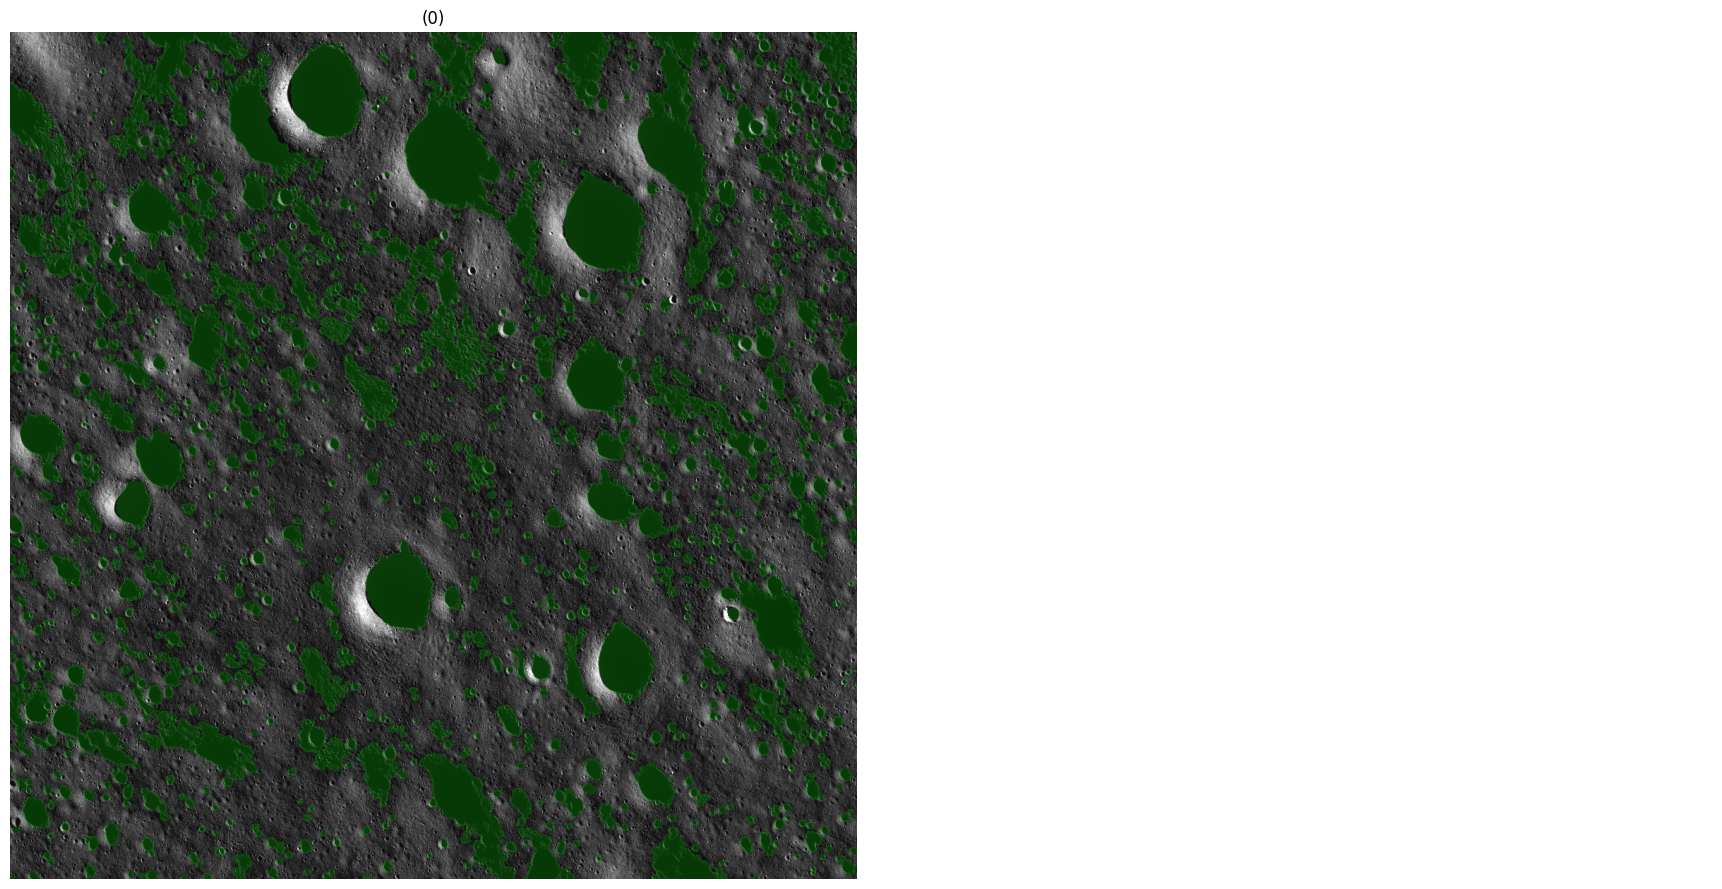

In [43]:
plot_images_list([
    overlay_segmented_black
], n_cols = 2, max_width = 22)

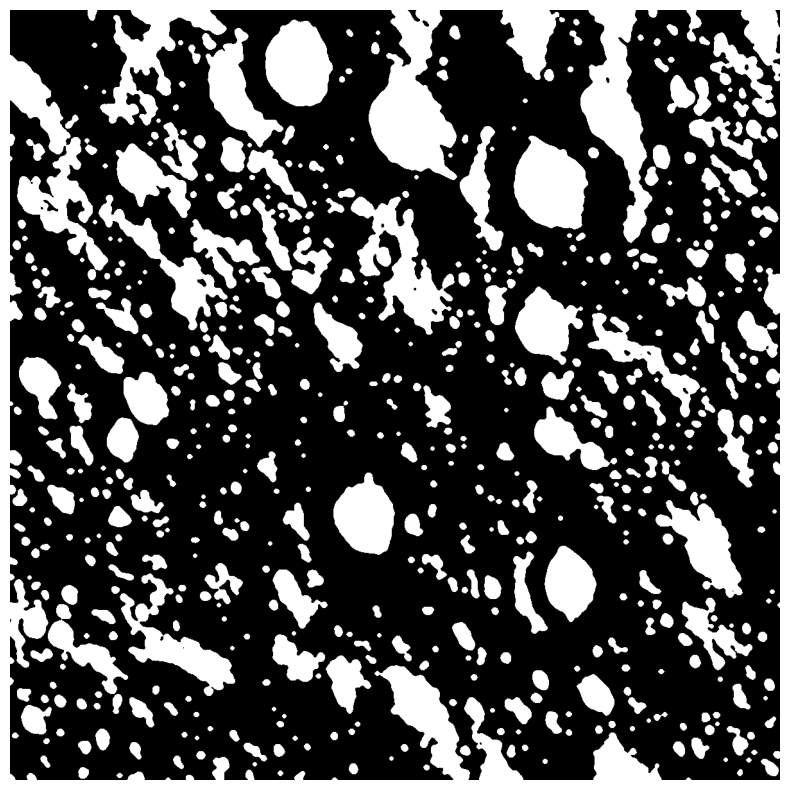

In [44]:
img_gaussian = cv2.medianBlur(smoothed,7)
show_img(img_gaussian)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


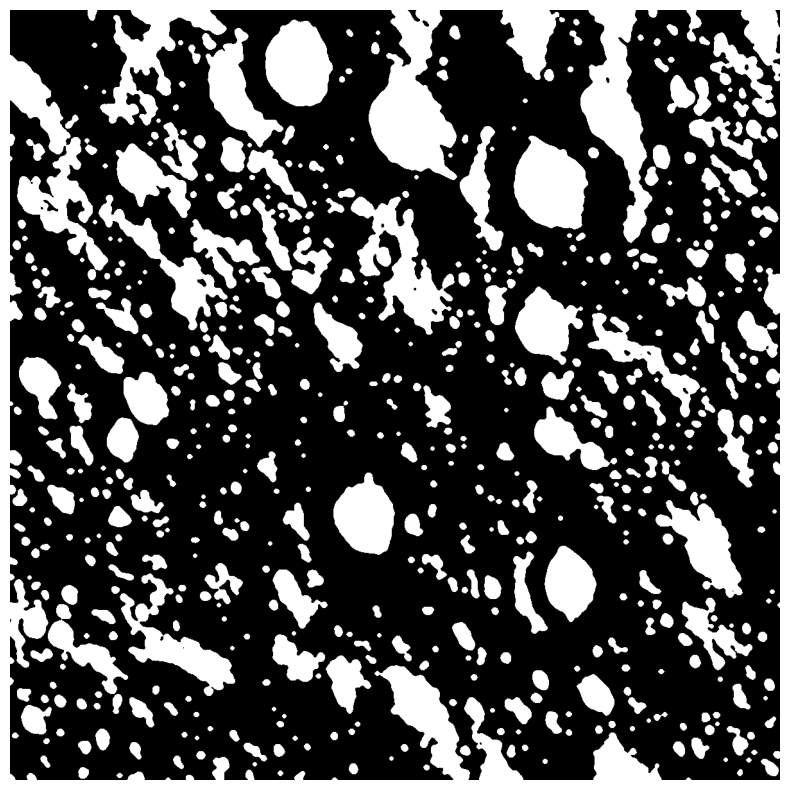

In [29]:
cluster_result = terneary_clustering_thresholding(img_gaussian)
show_img(cluster_result)

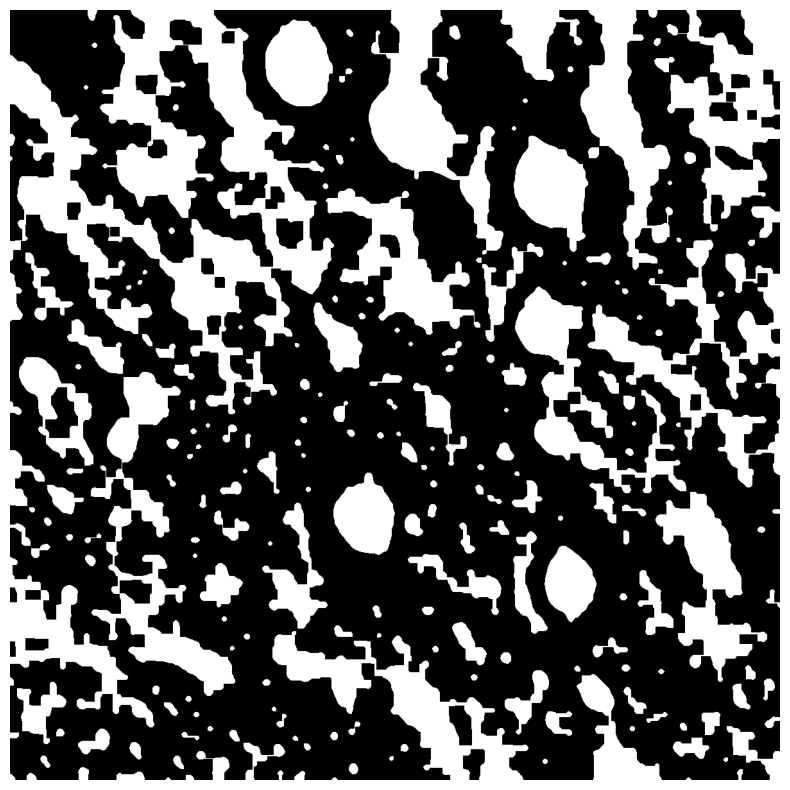

In [30]:
final_filtering = erosion_and_dialation_using_stream(
    cluster_result,
    stream = 'DE',
    iterations = 1,
    kernel = get_elliptic_element(7,0)
)
show_img(final_filtering)

In [31]:
final = combined_transforms_2(
    final_filtering,
    median_blur_kwargs={
        'ksize' : 5
    },
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_labels':True,
        'min_circularity_threshold' : 0.7,
        'min_bbox_area_threshold' : 200,
        'max_bbox_area_threshold' : 360000,
    },
    detect_bound_islands_with_stats_white_kwargs={
        'ret_labels':True,
        'min_circularity_threshold' : 0.7,
        'min_area_threshold' : 0,
        'max_area_threshold' : 0,
        'min_bbox_area_threshold' : 0,
        'max_bbox_area_threshold' : 0,
    }
)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [32]:
# show_img(final['mask'])

In [36]:
final['black_stats_df'].loc[:,'bbox_area_and_area_ratio']  = final['black_stats_df']['bbox_area'] / final['black_stats_df']['area'] 

In [37]:
final['black_stats_df']

index  label_id  coords_x  coords_y  width  height    area  bbox_area  \
0       3         4     330.0      33.0   20.0    19.0   355.0      380.0   
1       5         6     196.0     101.0   34.0    30.0   892.0     1020.0   
2       6         7    1124.0     100.0   29.0    22.0   585.0      638.0   
3       8         9    1149.0     156.0   15.0    15.0   213.0      225.0   
4      11        12      89.0     300.0   21.0    27.0   509.0      567.0   
5      12        13     415.0     325.0   42.0    47.0  1609.0     1974.0   
6      13        14     577.0     350.0   31.0    36.0   803.0     1116.0   
7      14        15     298.0     387.0   20.0    25.0   460.0      500.0   
8      15        16     319.0     416.0   16.0    17.0   260.0      272.0   
9      16        17     307.0     476.0   22.0    30.0   577.0      660.0   
10     17        18    1186.0     497.0   14.0    23.0   295.0      322.0   
11     19        20    1060.0     599.0   17.0    25.0   404.0      425.0   
12     20        21     171.0     888.0   50.0    37.0  1408.0     1850.0   
13     22        23      24.0     979.0   36.0    19.0   633.0      684.0   

            c_x         c_y  circularity  bbox_area_and_area_ratio  
0    339.780273   42.276058     0.887988                  1.070423  
1    213.119949  114.662560     0.818088                  1.143498  
2   1137.362427  110.670082     0.832948                  1.090598  
3   1156.000000  163.000000     0.897224                  1.056338  
4     98.447937  312.227905     0.826782                  1.113949  
5    435.115601  346.776245     0.766435                  1.226849  
6    593.374817  365.697388     0.700191                  1.389788  
7    307.284790  399.204346     0.864118                  1.086957  
8    326.500000  424.000000     0.887525                  1.046154  
9    317.389954  489.778168     0.805803                  1.143847  
10  1192.969482  507.694916     0.774742                  1.091525  
11  1068.170776  611.178223     0.826992                  1.051980  
12   196.891342  904.578857     0.729000                  1.313920  
13    40.830963  988.074280     0.750505                  1.080569

In [38]:
filtered_df = final['black_stats_df'][final['black_stats_df']['bbox_area_and_area_ratio'] >= (4 / np.pi) - 0.1]

In [39]:
filtered_df

index  label_id  coords_x  coords_y  width  height    area  bbox_area  \
5      12        13     415.0     325.0   42.0    47.0  1609.0     1974.0   
6      13        14     577.0     350.0   31.0    36.0   803.0     1116.0   
12     20        21     171.0     888.0   50.0    37.0  1408.0     1850.0   

           c_x         c_y  circularity  bbox_area_and_area_ratio  
5   435.115601  346.776245     0.766435                  1.226849  
6   593.374817  365.697388     0.700191                  1.389788  
12  196.891342  904.578857     0.729000                  1.313920

In [40]:
final.keys()

dict_keys(['coarse_mask', 'mask', 'white_stats_df', 'white_label_image', 'black_stats_df', 'black_label_image'])

In [41]:
final_w_bbox = draw_bounding_boxes_from_rects(
    adapted,
    filtered_df[['coords_x','coords_y','width','height']].to_numpy(dtype = np.int32),
    shade = 0
)

NameError: name 'adapted' is not defined

In [ ]:
show_image(final_w_bbox)

In [ ]:
show_img(final['mask'])

In [ ]:
plot_images_list([
    final['mask'],
    final['black_bounding_box'],
],max_width = 22,n_cols = 2)

In [ ]:
mask = final['mask']
show_img(((mask == mask.min()))*np.uint8(255))

In [ ]:

def morph_shape(val):
    if val == 0:
        return cv2.MORPH_RECT
    elif val == 1:
        return cv2.MORPH_CROSS
    elif val == 2:
        return cv2.MORPH_ELLIPSE 
erosion_shape = morph_shape(2)
erosion_size = 10
 
element = cv2.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),
 (erosion_size, erosion_size))


In [ ]:
def get_elliptic_element(erosion_size,shape = 2):
    return cv2.getStructuringElement(shape , (2 * erosion_size + 1, 2 * erosion_size + 1),(erosion_size, erosion_size))
    

In [ ]:
mask = final['mask']

In [ ]:
eroded_dialated = ((mask == mask.min()))*np.uint8(255)
# eroded_dialated = erosion_and_dialation_using_stream(((mask == mask.min()) | (mask == mask.max()))*np.uint8(255), 'ED',1, element)
eroded_dialated = erosion_and_dialation_using_stream(eroded_dialated, 'E',1, get_elliptic_element(3,0))

eroded_dialated = erosion_and_dialation_using_stream(eroded_dialated, 'D',1, get_elliptic_element(3,0))


show_img(eroded_dialated)

In [ ]:
# final_after_erosion = combined_transforms(
#     eroded_dialated,
#     median_blur_kwargs={
#         'ksize' : 7
#     },
#     detect_bound_islands_with_stats_black_kwargs = {
#         'ret_labels' : True,
#         'min_bbox_area_threshold':200,
#         'min_area_threshold' : 0,
#         'min_circularity_threshold' : 0.6,
#     },
#     detect_bound_islands_with_stats_white_kwargs={
#         'ret_labels' : True,
#         'min_area_threshold':0,
#         'min_bbox_area_threshold':0,
#         'min_circularity_threshold' : 0.5,
#     }
# )

In [ ]:
final_after_erosion_data = detect_bound_islands_with_stats(
    mask_image=eroded_dialated,
    **{
        'ret_labels' : False,
        'min_bbox_area_threshold':200,
        'min_circularity_threshold' : 0.7,
    }

)

In [ ]:
final_after_erosion_data['df']

In [ ]:
final_w_bbox = draw_bounding_boxes_from_rects(
    adapted,
    final_after_erosion_data['df'][['coords_x','coords_y','width','height']].to_numpy(dtype = np.int32),
    shade = 255
)

In [ ]:
show_img(final_w_bbox)

In [ ]:
params = cv2.SimpleBlobDetector_Params() 
params.filterByColor = True
params.blobColor = 255

# params.minDistBetweenBlobs = 1
# params.minRepeatability = 1

# params.filterByArea = True
# params.minArea = 100
# params.maxArea = 3000
  
# Set Circularity filtering parameters 
# params.filterByCircularity = True 
# params.minCircularity = 0.3
  
# Set Convexity filtering parameters 
# params.filterByConvexity = True
# params.minConvexity = 0.9
      
# # Set inertia filtering parameters 
# params.filterByInertia = True
# params.minInertiaRatio = 0.5
  
# Create a detector with the parameters 
detector = cv2.SimpleBlobDetector_create(params) 
      
# Detect blobs 
keypoints = detector.detect((final['mask']  == final['mask'].min())*np.uint8(255)) 
  
# Draw blobs on our image as red circles 
 
blobs = cv2.drawKeypoints(img_slice[:600,600:1200], keypoints, np.array([]), (0, 0, 255), 
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
                         )

In [ ]:
keypoints[0].class_id


In [ ]:
show_img(blobs)

In [ ]:
params = cv2.SimpleBlobDetector_Params() 
params.filterByColor = True
params.blobColor = 255

params.minDistBetweenBlobs = 1
params.minRepeatability = 1

# params.filterByArea = True
# params.minArea = 100
# params.maxArea = 3000
  
# Set Circularity filtering parameters 
# params.filterByCircularity = True 
# params.minCircularity = 0.3
  
# Set Convexity filtering parameters 
# params.filterByConvexity = True
# params.minConvexity = 0.9
      
# # Set inertia filtering parameters 
# params.filterByInertia = True
# params.minInertiaRatio = 0.5
  
# Create a detector with the parameters 
detector = cv2.SimpleBlobDetector_create(params) 
      
# Detect blobs 
keypoints = detector.detect((blurred_thresholded  == blurred_thresholded.min())*np.uint8(255)) 
  
# Draw blobs on our image as red circles 
 
blobs = cv2.drawKeypoints(img_slice, keypoints, np.array([]), (0, 0, 255), 
#                           cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
                         ) 

In [ ]:
show_img(blobs,(5,5))

## Downsampled_image

In [ ]:
img = cv2.imread(
    '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6/dataset/ch2_ohr_ncp_20190906T1246532096_d_img_d18/browse/calibrated/20190906/ch2_ohr_ncp_20190906T1246532096_b_brw_d18.png',
#     '/kaggle/input/chandrayan-ohrc-dataset/ch2_ohr_ncp_20240425T1406019344_d_img_d18/browse/calibrated/20240425/ch2_ohr_ncp_20240425T1406019344_b_brw_d18.png'
#     '/kaggle/input/chandrayan-ohrc-dataset/ch2_ohr_ncp_20240406T0052354542_d_img_d18/browse/calibrated/20240406/ch2_ohr_ncp_20240406T0052354542_b_brw_d18.png'
)
img.shape

In [ ]:
h,w,img_slices_morph_df,img_slices = slice_and_plot(morph_img,150,150)

In [ ]:
plot_images(img_slices_morph_df.iloc[:,:].to_numpy(),n_cols = 3)

# Slicing from a sliding window

In [ ]:
base_dirs = [
    '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6',
    '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/7',
    '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/14',
]

In [ ]:
image_paths  = []
for base_dir in base_dirs:
    image_paths.extend(get_paths_by_re(base_dir,'dataset/**/browse/calibrated/**/*.png'))
print(len(image_paths))
pprint(image_paths[:5])

In [ ]:
# image_paths = [
#     '/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/6/dataset/ch2_ohr_ncp_20190906T1246532096_d_img_d18/browse/calibrated/20190906/ch2_ohr_ncp_20190906T1246532096_b_brw_d18.png'
# ]

In [ ]:
params = {
    'median_blur_kwargs' : {'ksize': 7},
    'detect_bound_islands_with_stats_white_kwargs':{
        'ret_labels': True,
        'min_area_threshold':0,
        'min_circularity_threshold' : 0.5,
    },
    'detect_bound_islands_with_stats_black_kwargs':{
        'ret_labels': True,
        'min_bbox_area_threshold':400,
        'min_area_threshold' : 123,
        'min_circularity_threshold' : 0.5,
    },
}
def resize_image_with_aspect_ratio(image, max_size=1200):
    h, w = image.shape[:2]

    # Determine the scale factor and new dimensions
    if h > w:
        scale_factor = max_size / h
        new_h = max_size
        new_w = int(w * scale_factor)
    else:
        scale_factor = max_size / w
        new_w = max_size
        new_h = int(h * scale_factor)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))

    return resized_image
def get_combined_df(img):
    img = resize_image_with_aspect_ratio(img)
    combine = combined_transforms_temp(img,**params)
    output_dict = {}
    mask = combine.get('mask')
    white_stats_df = combine.get('white_stats_df')
    white_label_image = combine.get('white_label_image')
    black_stats_df = combine.get('black_stats_df')
    black_label_image = combine.get('black_label_image')
    return {
        'mask': mask,
        'white_stats_df': white_stats_df,
        'white_label_image': white_label_image,
        'black_stats_df': black_stats_df,
        'black_label_image': black_label_image,
    } 

def slice_and_extract_bbox_data(img, slice_height, slice_width, x_offset = 0, y_offset = 0):
    h,w = img.shape[:2]
    data = []
    for i in range(0,h ,slice_height):
        for j in range(0,w ,slice_width):
            d = {
                'x_start' : j + x_offset,
                'y_start' : i + y_offset,
                'slice_height' :  min(slice_height,(h - i)),
                'slice_width' :  min(slice_width,(w - j)),
            }
            
            d.update(get_combined_df(img[i:i + slice_height, j:j+slice_width]))
            data.append(d)
    return data


def get_slices_from_image_path(img_path, slice_height, slice_width,image = None ,img_preprocess_func = lambda x,*args,**kwargs : x, img_preprocess_args = [], img_preprocess_kwargs = {}):
    if image is None:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = img_preprocess_func(image,*img_preprocess_args,**img_preprocess_kwargs)
    df = pd.DataFrame(slice_and_extract_bbox_data(image, slice_height, slice_width))
    df['img_path'] = img_path
    return df

In [ ]:
def combined_transforms_temp(
    image,
    adaptive_intensity_scaling_args = [],
    adaptive_intensity_scaling_kwargs = {'quantiles' : [0.05,0.95]},
    terneary_clustering_thresholding_args = [],
    terneary_clustering_thresholding_kwargs = {},
    median_blur_args = [],
    median_blur_kwargs = {'ksize' : 7},
    detect_bound_islands_with_stats_white_args = [],
    detect_bound_islands_with_stats_white_kwargs = {
        'ret_labels':True,
    },
    detect_bound_islands_with_stats_black_args = [],
    detect_bound_islands_with_stats_black_kwargs = {
        'ret_labels':True,
    },
):
    """
    Don't change anything unless you understand the functions used in it. The name of parameters are obvious. kwargs are keyword arguments and args are normal function arguments
    It returns the dictionary of following:
    'coarse_mask' : The mask before the median blur and after terneary thresholding
    'mask' : The mask after mediam blur
    """
#     image = adaptive_intensity_scaling(image,*adaptive_intensity_scaling_args,**adaptive_intensity_scaling_kwargs)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    coarse_mask = terneary_clustering_thresholding(image,*terneary_clustering_thresholding_args, **terneary_clustering_thresholding_kwargs)
    mask = cv2.medianBlur(coarse_mask,*median_blur_args,**median_blur_kwargs)
    white_stats = detect_bound_islands_with_stats(
        (mask == mask.max())*np.uint8(255),*detect_bound_islands_with_stats_white_args,**detect_bound_islands_with_stats_white_kwargs
    )
    black_stats = detect_bound_islands_with_stats(
        (mask == mask.min())*np.uint8(255),*detect_bound_islands_with_stats_black_args,**detect_bound_islands_with_stats_black_kwargs
    )
    return {
        'coarse_mask' : coarse_mask,
        'mask' : mask,
        'white_stats_df' : white_stats.get('df'),
        'white_label_image' : white_stats.get('label_image'),
        'black_stats_df' : black_stats.get('df'),
        'black_label_image' : black_stats.get('label_image'),
    }

In [ ]:
# new_df = combined_transforms_temp(
#     item_image_slice,
#         median_blur_kwargs={
#         'ksize' : 7
#     },
#     detect_bound_islands_with_stats_black_kwargs = {
#         'ret_labels':True,
#         'min_circularity_threshold' : 0.5,
#         'min_bbox_area_threshold' : 200,
        
#     },
#     detect_bound_islands_with_stats_white_kwargs={
#         'ret_labels':True,
#         'min_circularity_threshold' : 0.6,
#         'min_area_threshold' : 0,
#         'max_area_threshold' : 0,
#         'min_bbox_area_threshold' : 0,
#         'max_bbox_area_threshold' : 0,
#     }
# )

In [ ]:
THRESHOLD_FOR_COMBINATION = 1024
IOU_THRESHOLD = 0.15
AREA_BIAS = 50
def intersection_area(rects1, rects2):
    """
    Calculate the intersection area of two rectangles.

    Parameters:
    rect1, rect2: NumPy arrays of shape (4,) where
        [x, y, w, h] are the coordinates of the top-left corner and dimensions of the rectangle.

    Returns:
    The area of the intersection of the two rectangles.
    """
    x1 = rects1[:, 0]
    y1 = rects1[:, 1]
    w1 = rects1[:, 2]
    h1 = rects1[:, 3]

    x2 = rects2[:, 0]
    y2 = rects2[:, 1]
    w2 = rects2[:, 2]
    h2 = rects2[:, 3]

    x_inter1 = np.maximum(x1, x2)
    y_inter1 = np.maximum(y1, y2)
    x_inter2 = np.minimum(x1 + w1, x2 + w2)
    y_inter2 = np.minimum(y1 + h1, y2 + h2)

    inter_width = np.maximum(0, x_inter2 - x_inter1)
    inter_height = np.maximum(0, y_inter2 - y_inter1)

    return inter_width * inter_height

def union_area(rects1, rects2):
    """
    Calculate the union area of two sets of rectangles.

    Parameters:
    rects1, rects2: NumPy arrays of shape (n, 4) where
        [x, y, w, h] are the coordinates of the top-left corner and dimensions of the rectangles.

    Returns:
    A NumPy array of shape (n,) containing the union areas.
    """
    inter_area = intersection_area(rects1, rects2)
    
    rects1_area = rects1[:, 4] 
    rects2_area = rects2[:, 4]

    return rects1_area + rects2_area - inter_area

def calculate_iou(rects1, rects2):
    """
    Calculate the Intersection over Union (IoU) of two sets of rectangles.

    Parameters:
    rects1, rects2: NumPy arrays of shape (n, 4) where
        [x, y, w, h] are the coordinates of the top-left corner and dimensions of the rectangles.

    Returns:
    A NumPy array of shape (n,) containing the IoU values.
    """
    inter_area = intersection_area(rects1, rects2)
    union_area_val = union_area(rects1, rects2)
    
    return inter_area / union_area_val
def get_threshold_iou_bounding_box(rects1, rects2):
    x1 = rects1[:, 0]
    y1 = rects1[:, 1]
    w1 = rects1[:, 2]
    h1 = rects1[:, 3]

    x2 = rects2[:, 0]
    y2 = rects2[:, 1]
    w2 = rects2[:, 2]
    h2 = rects2[:, 3]

    x_min = np.minimum(x1, x2)
    y_min = np.minimum(y1, y2)
    w_max = np.maximum(x1 + w1, x2 + w2) - x_min
    h_max = np.maximum(y1 + h1, y2 + h2) - y_min
    max_dim = np.maximum(w_max,h_max)
    return np.vstack([x_min,y_min,max_dim,max_dim],dtype=np.int32).T
    
def get_bounding_box_matrix(white_arr : np.ndarray,black_arr:np.ndarray):
    detected_bounds = []
    for black_rect in black_arr:
        desired_areas = np.abs(np.log2((white_arr[:,4] + AREA_BIAS) / (black_rect[4] + AREA_BIAS)))
        desired_areas = desired_areas <= THRESHOLD_FOR_COMBINATION
        white_rect = white_arr[desired_areas]
        ious = calculate_iou(black_rect.reshape(1,-1),white_rect)
        detected_bounds.append(
            get_threshold_iou_bounding_box(
                black_rect.reshape(1,-1),
                white_rect[ious >= IOU_THRESHOLD]
            )
        )
    return np.vstack(detected_bounds)
        
def draw_bounding_boxes(img = None, img_path = None, rectangles = None):
        image = None
        if img is not None: 
            image = img.copy()
            image = image.reshape(image.shape[0],image.shape[1],-1) + np.zeros((1,1,3), dtype ='uint8')
        elif img_path is not None:
            image = cv2.imread(img_path)
        for (x, y, w, h) in rectangles:
            dim = max(w,h)
            top_left = (x, y)
            bottom_right = (x + dim, y + dim)
            color = (0, 255, 0)  # Green color in BGR
            thickness = 2  # Thickness of the bounding box
            image = cv2.rectangle(image, top_left, bottom_right, color, thickness)
        return image
        
def slice_bounding_boxes(image, bounding_boxes):
    """
    Slices rectangular regions from an image based on bounding boxes.

    Parameters:
    - image: np.ndarray, input image.
    - bounding_boxes: list of tuples or np.array of shape (n, 4), where each bounding box is (x, y, width, height).

    Returns:
    - slices: list of np.array, list of sliced image regions.
    """
    # Load the image

    slices = []

    # Iterate through the bounding boxes and slice the regions from the image
    for (x, y, w, h) in bounding_boxes:
        # Define the region of interest (ROI)
        roi = image[y:y + h, x:x + w]
        slices.append(roi)

    return slices

# Model Training


In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models

def preprocess_image(image, target_size):
    """
    Resize or pad the image to the target size based on whether it's square or not.

    Parameters:
    - image: np.array, the input image.
    - target_size: tuple of (height, width), the desired output size.

    Returns:
    - np.array, the resized or padded image.
    """
    height, width = target_size
    h, w, _ = image.shape

    if h == w:
        # Resize if the image is square
        image = cv2.resize(image, (width, height))
    else:
        # Pad then resize if the image is not square
        if h > w:
            # Pad width
            pad_left = (h - w) // 2
            pad_right = h - w - pad_left
            padded_image = cv2.copyMakeBorder(image, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            # Pad height
            pad_top = (w - h) // 2
            pad_bottom = w - h - pad_top
            padded_image = cv2.copyMakeBorder(image, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        # Resize to the target size after padding
        image = cv2.resize(padded_image, (width, height))

    return image

def get_image_embeddings(images, model, preprocess):
    """
    Get embeddings for a list of images using a pre-trained ResNet model.

    Parameters:
    - images: list of np.array, list of images to process.
    - model: PyTorch model, the ResNet model.
    - preprocess: torchvision.transforms.Compose, preprocessing pipeline.

    Returns:
    - list of np.array, list of image embeddings.
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():
        for image in images:
            # Preprocess the image
            input_tensor = preprocess(image)
            input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
            
            # Get the embedding
            output = model(input_batch)
            embeddings.append(output.squeeze().numpy())
    
    return embeddings



In [ ]:
resnet_model = models.resnet50(pretrained=True)
preprocess = transforms.Compose([
    transforms.ToPILImage(),  # Convert the image to PIL format
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])


target_size = (224, 224)  # ResNet input size
processed_images = [preprocess_image(img, target_size) for img in bbox_img_slices]

# Get embeddings
embeddings = get_image_embeddings(processed_images, resnet_model, preprocess)

In [ ]:
embeddings_arr = np.vstack(embeddings)

In [ ]:
sim_mat = cosine_similarity(embeddings_arr,embeddings_arr)

# Segmenting Algorithm

In [20]:
base_dirs = get_paths_by_re('/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/','*/dataset/*')
bin_image_paths = []
xml_paths = []    
for base_dir in base_dirs:
    bin_image_paths.extend(get_paths_by_re(base_dir,'data/calibrated/**/*.img'))
    xml_paths.extend(get_paths_by_re(base_dir,'data/calibrated/**/*.xml'))
    
bin_image_paths.sort()
xml_paths.sort()


In [12]:
# adapted = adaptive_intensity_scaling(img_slice,quantiles = [0.02,0.98])
# denoised_slice = cv2.fastNlMeansDenoising(img_slice, h=10, templateWindowSize=7, searchWindowSize=50)
def resize_image_with_aspect_ratio(image, max_size=1200):
    h, w = image.shape[:2]

    # Determine the scale factor and new dimensions
    if h > w:
        scale_factor = max_size / h
        new_h = max_size
        new_w = int(w * scale_factor)
    else:
        scale_factor = max_size / w
        new_w = max_size
        new_h = int(h * scale_factor)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image

def get_segmentation_mask(img_slice,max_size = 1000):
    img_slice = resize_image_with_aspect_ratio(img_slice, max_size = max_size)
    eroded_img_black = erosion_and_dialation_using_stream(
            img_slice,
            stream = 'E',
            iterations = 1,
            kernel = get_elliptic_element(3,2)
        )
    dilated_img_white = erosion_and_dialation_using_stream(
            img_slice,
            stream = 'D',
            iterations = 1,
            kernel = get_elliptic_element(3,2)
        )

    rescaled_img_white, min_val,max_val = adaptive_intensity_scaling(dilated_img_white,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
    clahe_adapted_white = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img_white)
    bias_adaption_white, min_val,max_val= adaptive_intensity_scaling(clahe_adapted_white,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)

    rescaled_img_black, min_val,max_val = adaptive_intensity_scaling(eroded_img_black,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
    clahe_adapted_black = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img_black)
    bias_adaption_black, min_val,max_val= adaptive_intensity_scaling(clahe_adapted_black,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
    return {
        'white_mask' : bias_adaption_white,
        'black_mask' : bias_adaption_black,
    }

In [13]:
def get_multi_threaded_data(
    max_workers,
    total_len,
    func,
    task_args=[],
    return_None=False,
    None_return_val=None,
    message="",
    verbose=False,
    verbose_error=False,
):
    data = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # List of tasks to be executed by the thread pool
        tasks = [executor.submit(func, *arg) for arg in task_args]
        success = 0
        fails = 0

        with tqdm(total=total_len, desc=message) as pbar:
            for future in tasks:
                try:
                    data.append(future.result())
                    pbar.update(1)
                    success += 1
                    if verbose:
                        print()
                except Exception as exc:
                    print(f"Task generated an exception: {exc}")
                    if return_None:
                        data.append(None_return_val)
                    if verbose_error:
                        traceback.print_exc()
                    fails += 1

        print(f"success : {success}, fail : {fails}")

    return data

In [23]:
def get_slice_from_binary_image_path(
    img_path,
    slice_height,
    slice_width,
    img_height,
    img_width,
    x_offset = 0,
    y_offset = 0,
    *args,
    **kwargs
):
    img_slice = extract_slice(
        file_path = img_path,
        width = img_width,
        height = img_height,
        x = x_offset,
        y = y_offset,
        slice_width = slice_width,
        slice_height = slice_height,
    )
    return img_slice

def get_segmentation_masks_from_slices(
    img_path,
    xml_path,
    slice_height,
    slice_width,
    slice_horizontal_stride,
    slice_vertical_stride,
    global_x_offset = 0, 
    global_y_offset = 0,
    strategy_on_edge_slice = 'leave',
    resized_height = 1000,
    resized_width = 1000,
    concurrent = False,
    *args,
    **kwargs,
):
    assert slice_height == slice_width , "For now keep slice height and slice width equal "
    assert resized_height == resized_width , "For now keep resized height and resized width equal "
    height, width = extract_image_shape(xml_path)
    data = []
    for x_offset in range(global_x_offset, width, slice_horizontal_stride):
        for y_offset in range(global_y_offset, height, slice_vertical_stride):
            if min(width - x_offset, slice_width) != slice_width:
                if strategy_on_edge_slice == 'leave':
                    continue
                elif strategy_on_edge_slice == 'square':
                    x_offset = width - slice_width
                else:
                    continue
                    
            if min(height - y_offset, slice_height) != slice_height:
                if strategy_on_edge_slice == 'leave':
                    continue
                elif strategy_on_edge_slice == 'square':
                    y_offset = height - slice_height 
                else:
                    continue
            
            img_slice = extract_slice(
                file_path = img_path,
                width = width,
                height = height,
                x = x_offset,
                y = y_offset,
                slice_width = slice_width,
                slice_height = slice_height,
            )
            
            d = {}
            d['img_path'] = img_path
            d['img_height'] = height
            d['img_width'] = width
            d['x_start'] = x_offset
            d['y_start'] = y_offset
            d['resized_height'] = resized_height
            d['resized_width'] = resized_width
            d['slice_height'], d['slice_width'] = img_slice.shape[:2]
            d.update(get_segmentation_mask(img_slice, resized_width))
            
            data.append(d)
    return data
            
def get_segmentation_masks_from_slices_threaded(
    img_path,
    xml_path,
    slice_height,
    slice_width,
    slice_horizontal_stride,
    slice_vertical_stride,
    global_x_offset = 0, 
    global_y_offset = 0,
    strategy_on_edge_slice = 'leave',
    resized_height = 1000,
    resized_width = 1000,
    concurrent = False,
    *args,
    **kwargs,
):
    assert slice_height == slice_width , "For now keep slice height and slice width equal "
    assert resized_height == resized_width , "For now keep resized height and resized width equal "
    height, width = extract_image_shape(xml_path)
    data = []
    for x_offset in range(global_x_offset, width, slice_horizontal_stide):
        for y_offset in range(global_y_offset, height, slice_vertical_stride):
            if min(width - x_offset, slice_width) != slice_width:
                if strategy_on_edge_slice == 'leave':
                    continue
                elif strategy_on_edge_slice == 'square':
                    x_offset = width - slice_width
                else:
                    continue
                    
            if min(height - y_offset, slice_height) != slice_height:
                if strategy_on_edge_slice == 'leave':
                    continue
                elif strategy_on_edge_slice == 'square':
                    y_offset = height - slice_height 
                else:
                    continue
            
            img_slice = extract_slice(
                file_path = img_path,
                width = width,
                height = height,
                x = x_offset,
                y = y_offset,
                slice_width = slice_width,
                slice_height = slice_height,
            )
            
            d = {}
            d['img_path'] = img_path
            d['img_height'] = height
            d['img_width'] = width
            d['x_start'] = x_offset
            d['y_start'] = y_offset
            d['resized_height'] = resized_height
            d['resized_width'] = resized_width
            d['slice_height'], d['slice_width'] = img_slice.shape[:2]
            d.update(get_segmentation_mask(img_slice, resized_width))
            
            data.append(d)
    return data
            
    

In [25]:
def get_img_slice_from_df_item(img_item_ser):
    img_slice = extract_slice(
        file_path = img_item_ser.img_path,
        width = img_item_ser.img_width,
        height = img_item_ser.img_height,
        x = img_item_ser.x_start,
        y = img_item_ser.y_start,
        slice_height = img_item_ser.slice_height,
        slice_width = img_item_ser.slice_width
    )
    img_slice = cv2.resize(img_slice,img_item_ser['white_mask'].shape[:2])
    return img_slice

def get_overlay_from_df_item(img_item_ser, white_threshold =230, black_threshold = 25, white_color = (255,0,0), black_color = (255,0,0), white_alpha = 0.3, black_alpha = 0.3):
    img_slice = get_img_slice_from_df_item(img_item_ser)
    img_slice = cv2.resize(img_slice,img_item_ser['white_mask'].shape[:2])
    white_overlay = overlay_segmentation_mask(img_slice,(img_item_ser['white_mask'] >= white_threshold) * np.uint8(255),color=white_color, alpha = white_alpha)
    black_overlay = overlay_segmentation_mask(white_overlay,(image_item['black_mask'] <= black_threshold) * np.uint8(255),color = black_color, alpha = black_alpha)
    return black_overlay

def get_overlay_from_df_item_after_postprocess(img_item_ser, func = lambda x,*args,**kwargs : x, func_args = [], func_kwargs = {}, overlay_on_image = False, white_threshold =230, black_threshold = 25, overlay_color = (255,0,0), overlay_alpha = 0.3):
    img_slice = get_img_slice_from_df_item(img_item_ser)
    img_slice = cv2.resize(img_slice,img_item_ser['white_mask'].shape[:2])
    combined_overlay = ((img_item_ser['white_mask'] >= white_threshold) | (image_item['black_mask'] <= black_threshold))*np.uint8(255)
    combined_overlay = func(combined_overlay,*func_args,**func_kwargs)
    if overlay_on_image:
        combined_overlay = overlay_segmentation_mask(img_slice,combined_overlay,color=overlay_color, alpha = overlay_alpha)
    return combined_overlay




In [26]:
def smoothing_func(image):
    smoothed = erosion_and_dialation_using_stream(
        image,
        stream = 'ED',
        iterations = 1,
        kernel = get_elliptic_element(4,2)
    )
    smoothed = erosion_and_dialation_using_stream(
        smoothed,
        stream = 'D',
        iterations = 1,
        kernel = get_elliptic_element(2,2)
    )
    return smoothed


In [27]:
gc.collect()

22370

In [28]:
# Params
class ParamsClass:
    def __init__(self):
        pass
    
params = ParamsClass()
params.slice_height = 1000
params.slice_width = 1000
params.slice_horizontal_stride = 1000
params.slice_vertical_stride = 1000
params.strategy_on_edge_slice  = 'square' #: Literal['leave' ,'continue' , 'square']
params.global_x_offset = 0
params.global_y_offset = 0
params.resized_height = 1000
params.resized_width = 1000


In [45]:
new_list = get_segmentation_masks_from_slices(
    img_path = bin_image_paths[1],
    xml_path = xml_paths[1],
    **params.__dict__
)

In [4]:
data_df = pd.DataFrame(new_list)

NameError: name 'pd' is not defined

In [5]:
data_df.columns

NameError: name 'data_df' is not defined

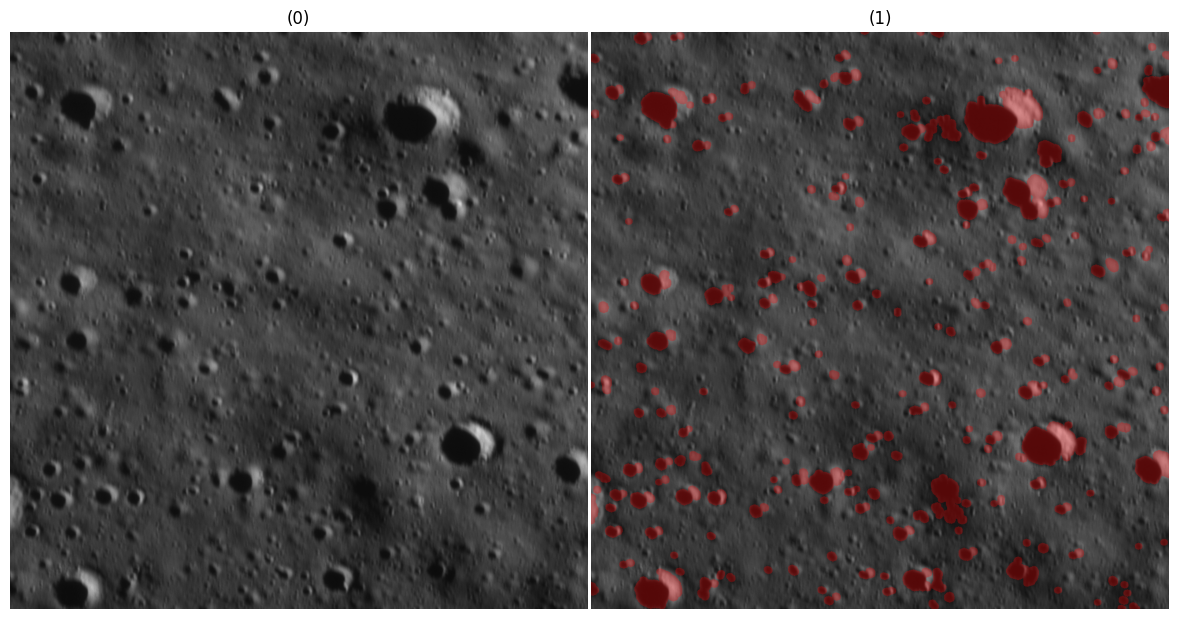

In [48]:
image_item = data_df.iloc[60]
plot_images_list([
    get_img_slice_from_df_item(image_item),
    get_overlay_from_df_item_after_postprocess(
        image_item,
        overlay_alpha = 0.3,
        func = smoothing_func,
        white_threshold=230,
        overlay_on_image=True
    )
], n_cols = 2, max_width=15)

In [49]:
plt.show()

In [29]:
def get_segmentation_mask_temp(img_slice,max_size = 1000, threshold = True, threshold_and_smooth = True):
    img_slice = resize_image_with_aspect_ratio(img_slice, max_size = max_size)
    eroded_img = erosion_and_dialation_using_stream(
            img_slice,
            stream = 'D',
            iterations = 1,
            kernel = get_elliptic_element(3,2)
        )
    rescaled_img, min_val,max_val = adaptive_intensity_scaling(eroded_img,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
    clahe_adapted = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img)
    # bias_adaption = adaptive_intensity_scaling(clahe_adapted,quantiles=[0.10,0.90], rescale = True)
    # clahe_adapted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50)).apply(bias_adaption)
    bias_adaption, min_val,max_val= adaptive_intensity_scaling(clahe_adapted,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
    mask = bias_adaption
    if threshold or threshold_and_smooth:
        mask = ((mask < 25))*np.uint8(255)
    if threshold_and_smooth:
        mask = erosion_and_dialation_using_stream(
            (mask == mask.max())*np.uint8(255),
            stream = 'ED',
            iterations = 1,
            kernel = get_elliptic_element(4,2)
        )
    return {
        'mask' : mask,
        'overlayed_mask' : None
    }

In [2]:
image_item = data_df.iloc[30]
seg_mask = get_segmentation_mask_temp(
    get_img_slice_from_df_item(image_item),
    threshold=False,
    threshold_and_smooth=False
)
white_region_mask = (seg_mask['mask'] > 230) * np.uint8(255)
white_overlay = overlay_segmentation_mask(get_img_slice_from_df_item(image_item),white_region_mask,color=(255,0,0), alpha = 0.3)
black_overlay = overlay_segmentation_mask(white_overlay,image_item['mask'],color = (255,0,0), alpha = 0.3)



NameError: name 'data_df' is not defined

In [3]:
plot_images_list([get_img_slice_from_df_item(image_item),black_overlay],2,22)

NameError: name 'plot_images_list' is not defined

In [ ]:
# img_slice = get_img_slice_from_df_item(image_item)
img_slice = resize_image_with_aspect_ratio(img_slice, max_size = 1000)
eroded_img_black = erosion_and_dialation_using_stream(
        img_slice,
        stream = 'E',
        iterations = 1,
        kernel = get_elliptic_element(3,2)
    )
dilated_img_white = erosion_and_dialation_using_stream(
        img_slice,
        stream = 'D',
        iterations = 1,
        kernel = get_elliptic_element(3,2)
    )

rescaled_img_white, min_val,max_val = adaptive_intensity_scaling(dilated_img_white,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
clahe_adapted_white = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img_white)
bias_adaption_white, min_val,max_val= adaptive_intensity_scaling(clahe_adapted_white,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)

rescaled_img_black, min_val,max_val = adaptive_intensity_scaling(eroded_img_black,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)
clahe_adapted_black = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(50, 50)).apply(rescaled_img_black)
bias_adaption_black, min_val,max_val= adaptive_intensity_scaling(clahe_adapted_black,quantiles=[0.01,0.99], rescale = True, ret_thresholds = True)

In [ ]:
white_overlay = overlay_segmentation_mask(img_slice,(bias_adaption_white > 230)*np.uint8(255),color=(255,0,0), alpha = 0.3)
black_overlay = overlay_segmentation_mask(white_overlay,(bias_adaption_black < 25)*np.uint8(255),color = (255,0,0), alpha = 0.3)

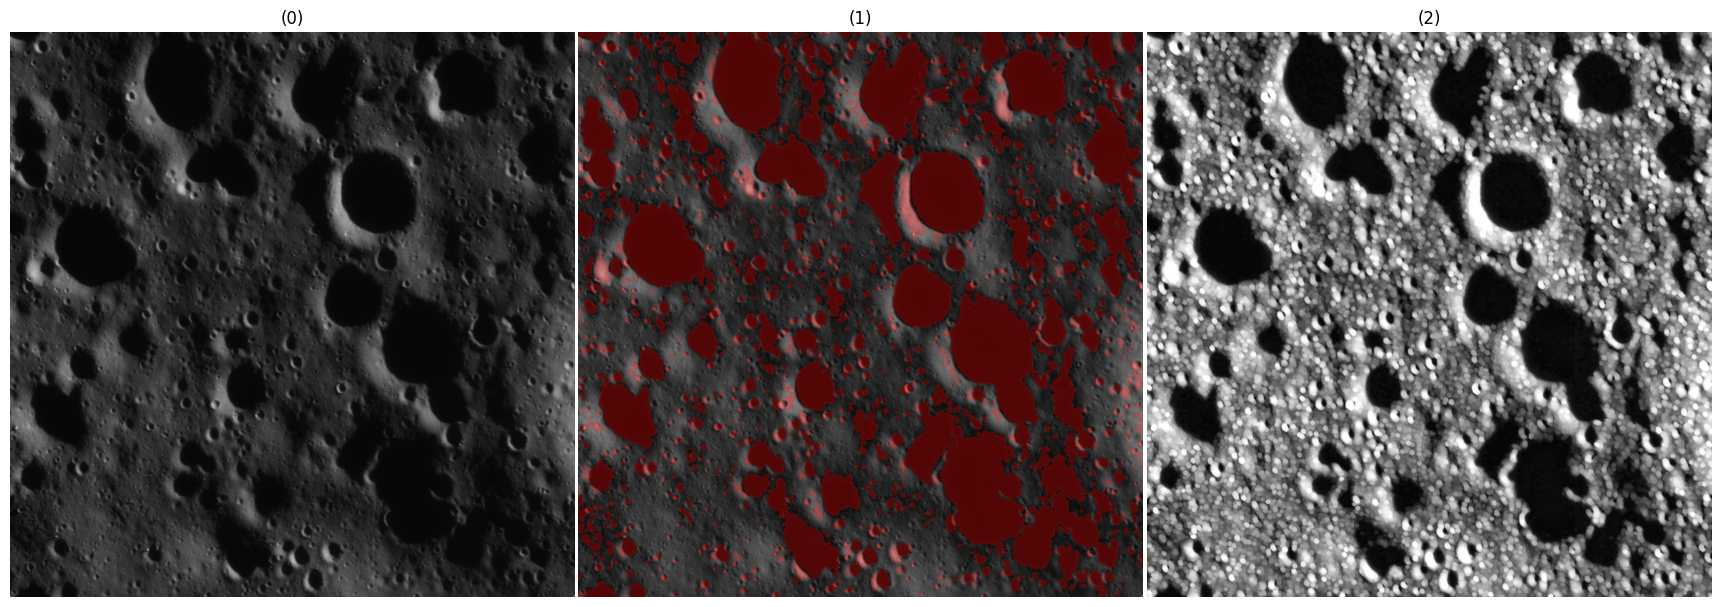

In [56]:
plot_images_list([img_slice,black_overlay,clahe_adapted_white],3,22)

In [ ]:
ch2_ohr_ncp_20190906T1246532096_d_img_d18

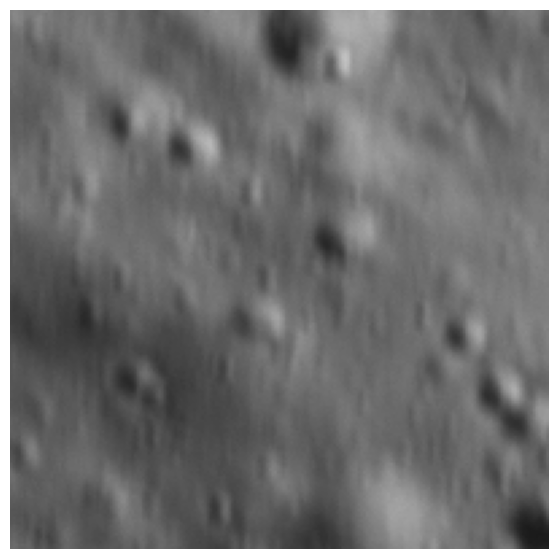

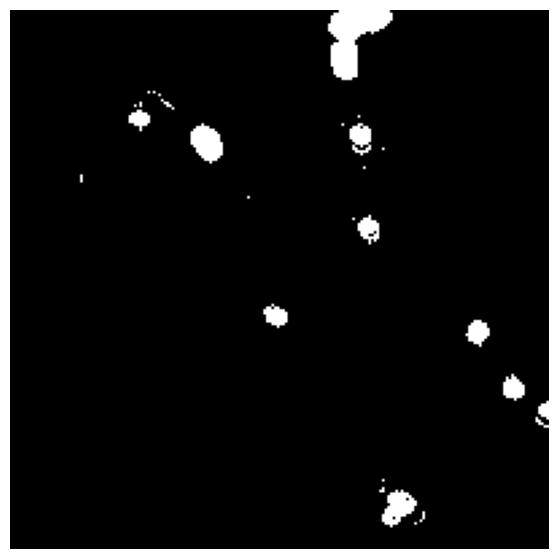

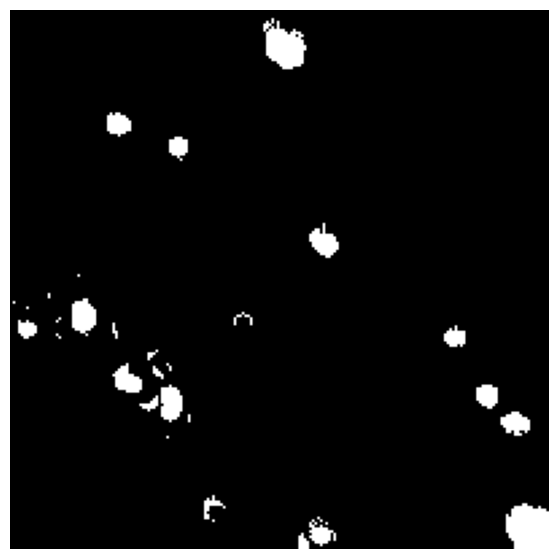

In [79]:
show_image(img_slice)
show_image((bias_adaption_white > 230)*np.uint8(255))
show_image((bias_adaption_black < 25)*np.uint8(255))

In [80]:
show_image(bias_adaption_white[500:700,300:500])
show_image(bias_adaption_black[500:700,300:500])
show_image((bias_adaption_white[500:700,300:500] > 230)*np.uint8(255))
show_image((bias_adaption_black[500:700,300:500] < 25)*np.uint8(255))
show_image(black_overlay[500:700,300:500])

ValueError: cannot reshape array of size 0 into shape (0,0,newaxis)

<Figure size 700x700 with 0 Axes>

In [ ]:
show_image(seg_mask['mask'])